# Forest Fire EDA
Authors: Rishikesh Majumder, Jake Mitchell, and Peter Kim

# _KEY FOR NAVIGATION_
Hey guys, I just wanted to give you a run down of how to navigate this document in it's current rough form.  Things that we need to talk about or work on are in the giant italicized marks.  Add these wherever you see work or movement to be done.  
# Used for overall title
# _I will be using these giant italicized title markings to signify things that we need to fix before we finish_
## Used for marking the sections from the lab 1 document
### Used for marking the secondary sections from the lab 1 document
#### Used for marking the indivdual variables in the sections


General structure looks like this: (may not be in order, this is from memory)<br>
- Introduction<br>
    - Research Question<br>
    - Load Data set<br>
    - Data descrition<br>
    - Data quality<br>
    - Data processing<br>
- Univariate analysis<br>
    - xy<br>
    - month<br>
    - day<br>
    - ffmc<br>
    - dmc<br>
    - dc<br>
    - isi<br>
    - temp<br>
    - rh<br>
    - wind<br>
    - rain<br>
    - area<br>
- Key relationships<br>
    - All of our general analysis<br>
    <br>
    - major relationships<br>
        - xy<br>
        - month<br>
        - ffmc<br>
        - temp<br>
        - rh<br>
    - secondary relationships<br>
        - day<br>
        - dmc<br>
        - dc<br>
    - No relationship<br>
        - isi<br>
        - wind<br>
        - rain<br>

- Secondary <br>
    - all of our general secondary analysis<br>
<br>
- Conclusion<br>

Packages Used:

In [72]:
library(dplyr)
library(ggplot2)
library(GGally)
library(ggcorrplot)
library(ggpubr)
library(car)
require(gridExtra)

In [73]:
# Make plots fit better on screen
#NOTE: this options line adjusts the size of plots.  We can use this to make our graphs fit the pages better.
w_h_ratio = 3/4
width = 6
options(repr.plot.width=width, repr.plot.height=width*w_h_ratio)

## Introduction

#### Research Question

#### Load Data Set

In [74]:
#forestfire
ff = read.csv("forestfires.csv")
head(ff)

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


#### Data Description

# _Need to pretty print this_

In [75]:
# 1. What types of variabes does it contain ?
# 2. How many observations are there ? 

summary(ff)
# There is no NA in each column, there are 517 observations
for (i in 1:length(ff[1,])) {
    print(sprintf("Does NA exist: %s   Number of observation in each column:  %i" , 
                  toString(is.na(length(ff[,i]))),length(ff[,i])))
}

       X               Y           month      day          FFMC      
 Min.   :1.000   Min.   :2.0   aug    :184   fri:85   Min.   :18.70  
 1st Qu.:3.000   1st Qu.:4.0   sep    :172   mon:74   1st Qu.:90.20  
 Median :4.000   Median :4.0   mar    : 54   sat:84   Median :91.60  
 Mean   :4.669   Mean   :4.3   jul    : 32   sun:95   Mean   :90.64  
 3rd Qu.:7.000   3rd Qu.:5.0   feb    : 20   thu:61   3rd Qu.:92.90  
 Max.   :9.000   Max.   :9.0   jun    : 17   tue:64   Max.   :96.20  
                               (Other): 38   wed:54                  
      DMC              DC             ISI              temp      
 Min.   :  1.1   Min.   :  7.9   Min.   : 0.000   Min.   : 2.20  
 1st Qu.: 68.6   1st Qu.:437.7   1st Qu.: 6.500   1st Qu.:15.50  
 Median :108.3   Median :664.2   Median : 8.400   Median :19.30  
 Mean   :110.9   Mean   :547.9   Mean   : 9.022   Mean   :18.89  
 3rd Qu.:142.4   3rd Qu.:713.9   3rd Qu.:10.800   3rd Qu.:22.80  
 Max.   :291.3   Max.   :860.6   Max.   :56.

[1] "Does NA exist: FALSE   Number of observation in each column:  517"
[1] "Does NA exist: FALSE   Number of observation in each column:  517"
[1] "Does NA exist: FALSE   Number of observation in each column:  517"
[1] "Does NA exist: FALSE   Number of observation in each column:  517"
[1] "Does NA exist: FALSE   Number of observation in each column:  517"
[1] "Does NA exist: FALSE   Number of observation in each column:  517"
[1] "Does NA exist: FALSE   Number of observation in each column:  517"
[1] "Does NA exist: FALSE   Number of observation in each column:  517"
[1] "Does NA exist: FALSE   Number of observation in each column:  517"
[1] "Does NA exist: FALSE   Number of observation in each column:  517"
[1] "Does NA exist: FALSE   Number of observation in each column:  517"
[1] "Does NA exist: FALSE   Number of observation in each column:  517"
[1] "Does NA exist: FALSE   Number of observation in each column:  517"


#### Data Quality

# _May want to make all of our matrix operations the same.  Deciding between scatterplotMatrix, pairs, ggpairs, and ggscatmat_

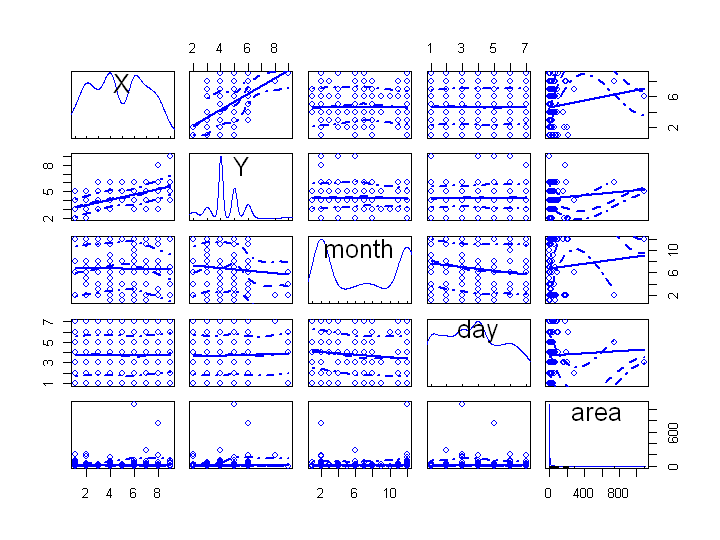

Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit smooth"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit smooth"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit smooth"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit negative part of the spread"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit negative part of the spread"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit negative part of the spread"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit smooth"

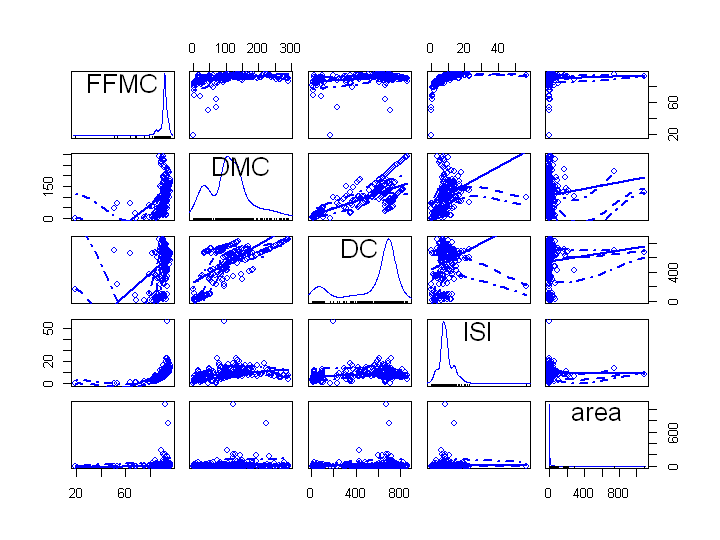

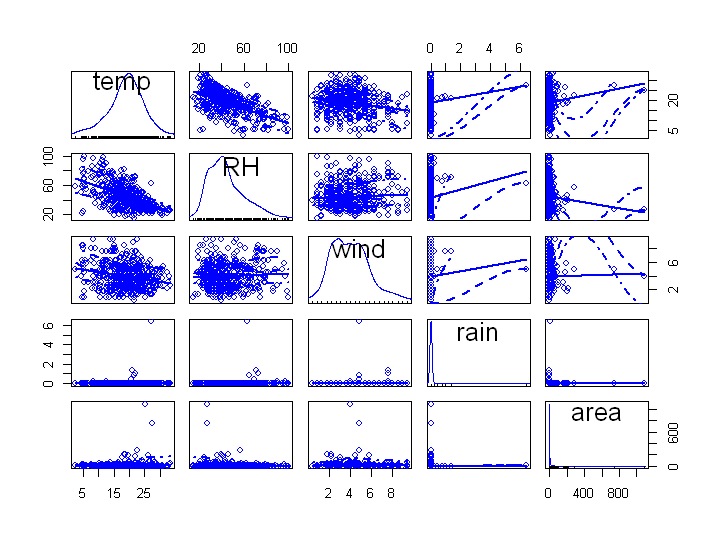

In [76]:
#3. Evaluate the data quality
# - Are there any issuews with data
# - Explain how you handled these potential issues
#options(repr.plot.height = 10, repr.plot.width = 10, repr.plot.pointsize = 22)
scatterplotMatrix(~X+Y+month+day+area, data=ff)
scatterplotMatrix(~FFMC+DMC+DC+ISI+area, data=ff)
scatterplotMatrix(~temp+RH+wind+rain +area, data=ff)

In [77]:
summary(ff$area)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.52   12.85    6.57 1090.84 

# _Peter: I don't know where you want to put all of this initial analysis, as in under individual variables or in this quality section.  Move all of this where you see fit!_

[1] 1.547389


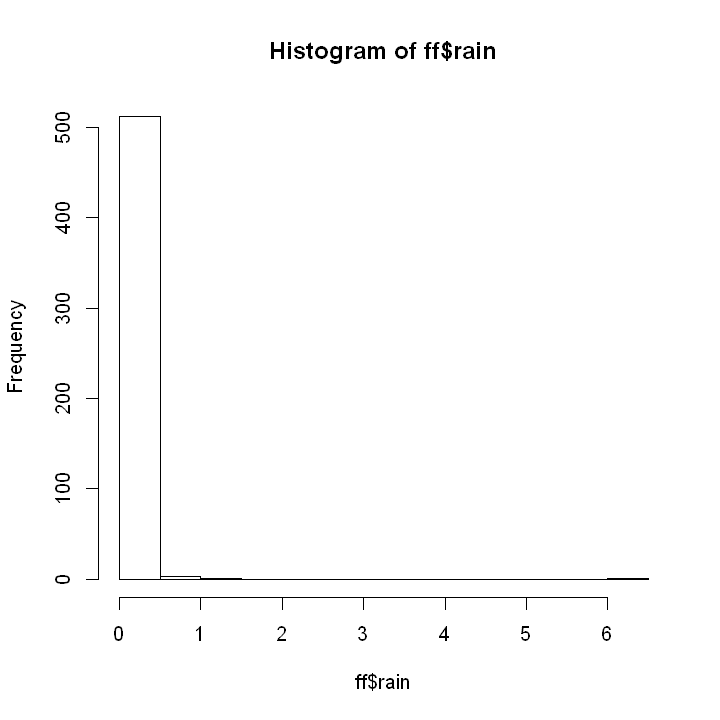

[1] 52.22437


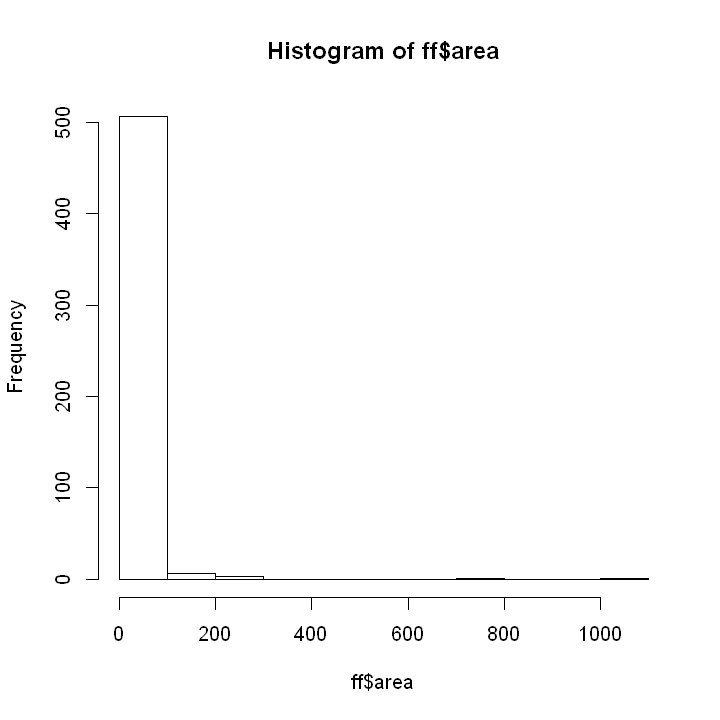

In [78]:
w_h_ratio = 4/4
width = 6
options(repr.plot.width=width, repr.plot.height=width*w_h_ratio)

hist(ff$rain)
non_zero_data = length(ff$rain[ff$rain>0]) /length(ff$rain) *100
print(non_zero_data)

hist(ff$area)
non_zero_data =length(ff$area[ff$area>0])/length(ff$area) *100
print(non_zero_data)

# Finding 1 : Only 1.54% of rain data is not zero 
# Finding 2 : Only 52.22% of area data is not zero 
# Conclusion: Data precision is not high enough. Considering thr fact that Area and Rain are crucial factors for fire,
# the data quality is not good. Because of the data imbalance and precision issue, correlation between area and all 
# the other factors don't look good. 

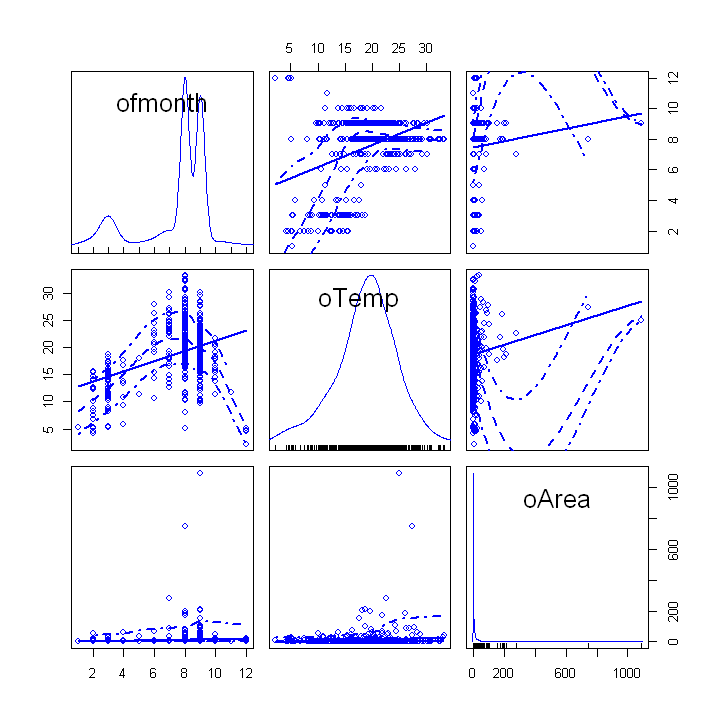

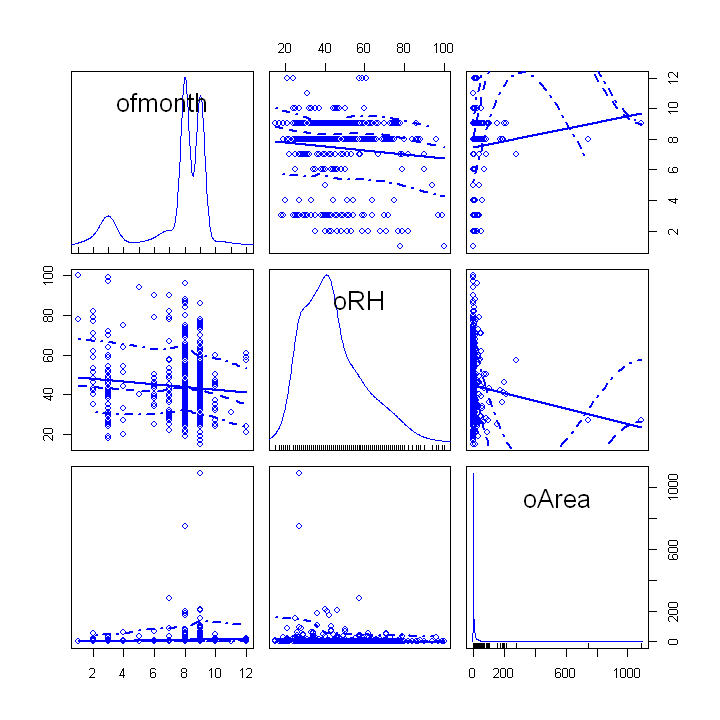

In [79]:
off=ff[order(ff$area),]
ofmonth=factor(off$month, levels = c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep","oct", "nov", "dec"))

# Entire data
oRH=off$RH
oTemp=off$temp
oArea=off$area
frame_data = data.frame(ofmonth, oArea, oRH, oTemp)

scatterplotMatrix(~ofmonth+ oTemp+ oArea, data=frame_data)
scatterplotMatrix(~ofmonth+ oRH+ oArea, data=frame_data)

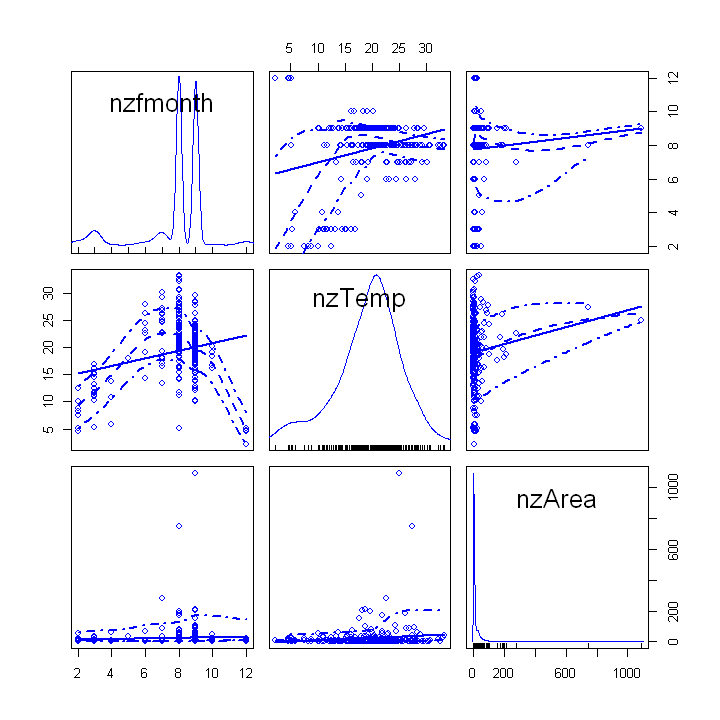

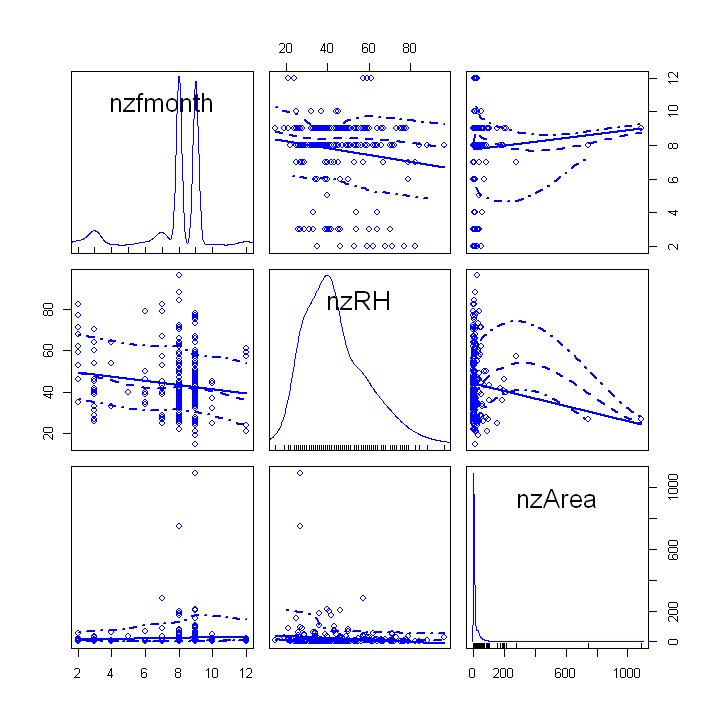

In [80]:
# Only non-zero data
L_zero=length(oArea[oArea==0])
nzArea= oArea[oArea>0]

nzff=off[248:517,]
nzfmonth=factor(nzff$month, levels = c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep","oct", "nov", "dec"))

nzRH=oRH[248:517]
nzTemp=oTemp[248:517]
nzArea=oArea[248:517]
nzlArea=log(oArea[248:517]+10)
frame_nzdata = data.frame(nzfmonth,nzArea, nzRH, nzTemp, nzlArea)


scatterplotMatrix(~nzfmonth+ nzTemp+ nzArea, data=frame_nzdata)
scatterplotMatrix(~nzfmonth+ nzRH+ nzArea, data=frame_data)

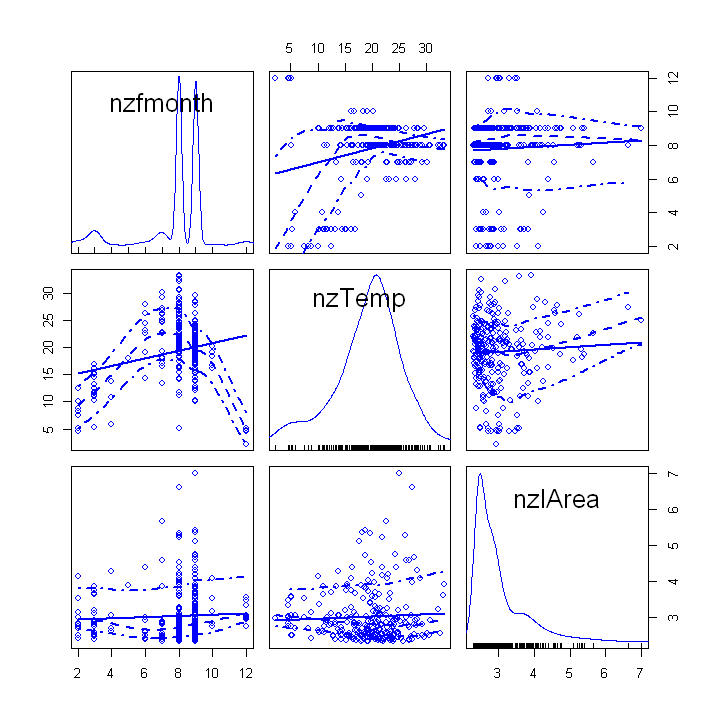

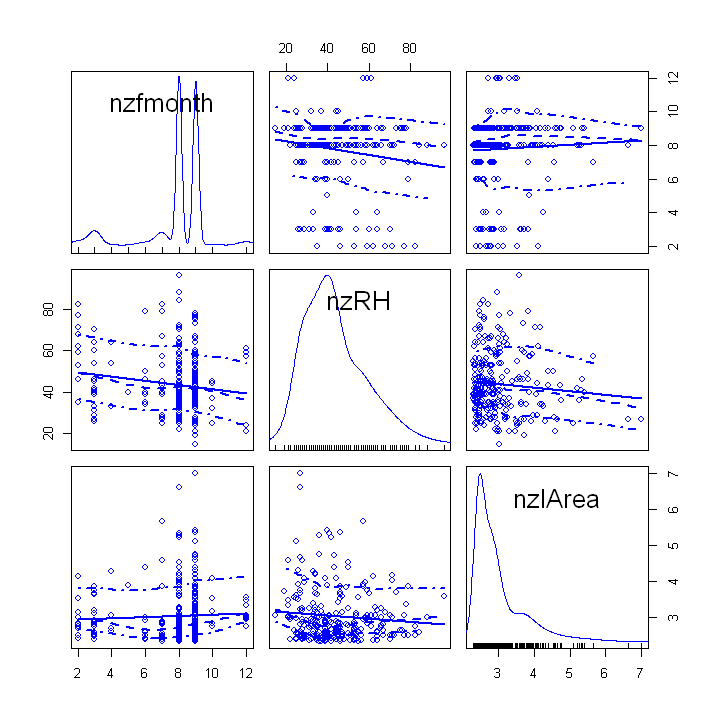

In [81]:
scatterplotMatrix(~nzfmonth+ nzTemp+ nzlArea, data=frame_nzdata)
scatterplotMatrix(~nzfmonth+ nzRH+ nzlArea, data=frame_data)

# _Will need to make severity data sets standard.  I'm thinking: all (ff), greater than 0 (pff positive forest fires), greater than 10 (bff big forest fires), and greater than 50 (sff severe forest fires)_

In [82]:
#Non 0 fires
nff = ff[ff$area>0,]
#big fires
bff = ff[ff$area>10,]
#severe fires
sff = ff[ff$area>50,]

numff = Filter(is.numeric, ff)
numNff = Filter(is.numeric, nff)
numBff = Filter(is.numeric, bff)
numSff = Filter(is.numeric, sff)

#### Data Processing

# _We will want to talk about using log areas and such here, as well as separtating the data sets into their different sizes.  Also any discussion of removing outliers._

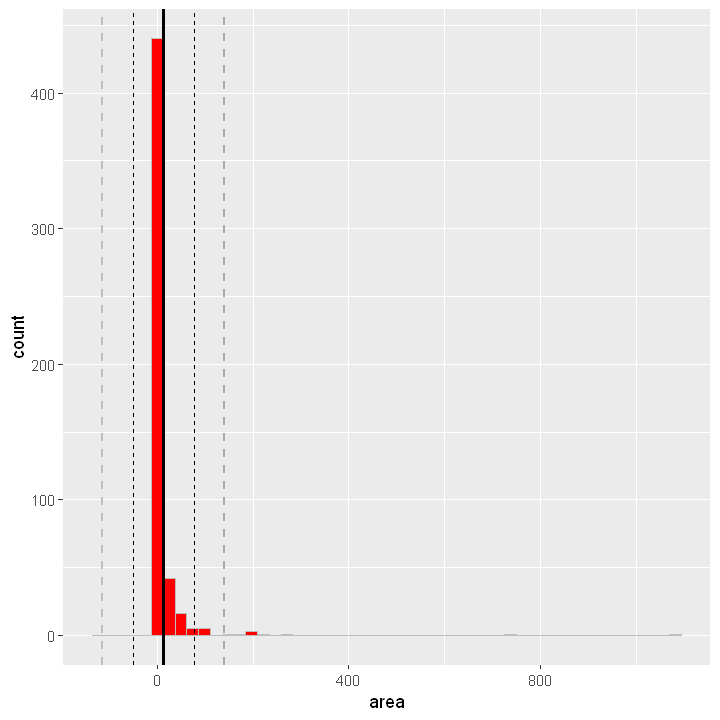

In [111]:
areaMean <- mean(ff$area)
sdArea <- sd(ff$area)

ggplot(ff, aes(x=area)) +
  geom_histogram(bins=50, fill="red", color="gray") + 
  geom_vline(aes(xintercept = areaMean), colour="black", size = 1) + 
  geom_vline(aes(xintercept = areaMean-sdArea), colour="black", size = 0.5, linetype="dashed") + 
  geom_vline(aes(xintercept = areaMean+sdArea), colour="black", size = 0.5, linetype="dashed") + 
  geom_vline(aes(xintercept = areaMean-2*sdArea), colour="gray", size = 0.75, linetype="dashed") + 
  geom_vline(aes(xintercept = areaMean+2*sdArea), colour="darkgray", size = 0.75, linetype="dashed")

We see that we have 270 fires with a non 0 area.  If we assume the most severe fires to be the top 10% of non 0 area fires, that would correlate to fires with an area greater than 50 hectares.  If we want to look at all significant fires, we can look at the top third, which would be fires over 10 hectares.

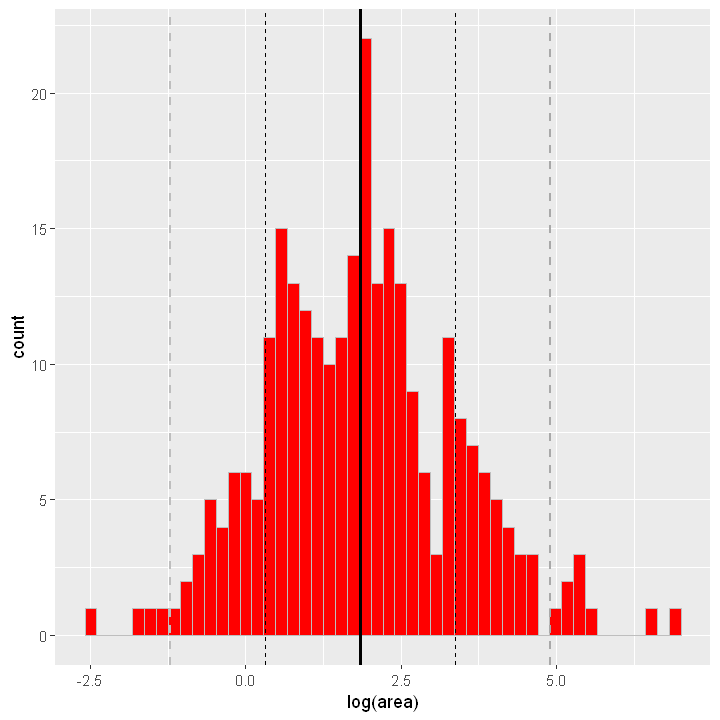

In [115]:
#Log transformation
logAreaMean <- mean(log(nff$area))
logSdArea <- sd(log(nff$area))

ggplot(nff, aes(x=log(area))) +
  geom_histogram(bins=50, fill="red", color="gray") + 
  geom_vline(aes(xintercept = logAreaMean), colour="black", size = 1) + 
  geom_vline(aes(xintercept = logAreaMean-logSdArea), colour="black", size = 0.5, linetype="dashed") + 
  geom_vline(aes(xintercept = logAreaMean+logSdArea), colour="black", size = 0.5, linetype="dashed") + 
  geom_vline(aes(xintercept = logAreaMean-2*logSdArea), colour="gray", size = 0.75, linetype="dashed") + 
  geom_vline(aes(xintercept = logAreaMean+2*logSdArea), colour="darkgray", size = 0.75, linetype="dashed")

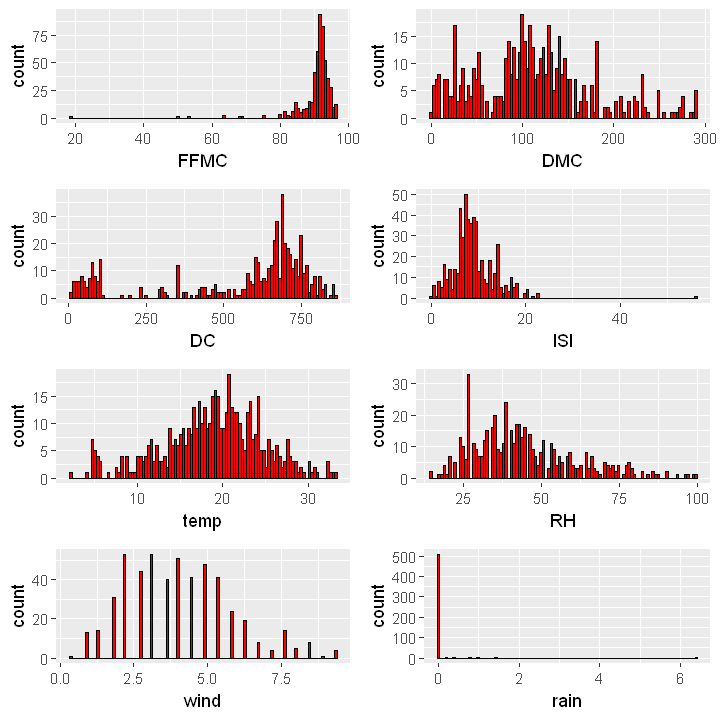

In [117]:
ffmcHist <- ggplot(ff, aes(x=FFMC)) + 
  geom_histogram(color="black", fill="red", bins = 100)

dmcHist <- ggplot(ff, aes(x=DMC)) + 
  geom_histogram(color="black", fill="red", bins = 100)

dcHist <- ggplot(ff, aes(x=DC)) + 
  geom_histogram(color="black", fill="red", bins = 100)

isiHist <- ggplot(ff, aes(x=ISI)) + 
  geom_histogram(color="black", fill="red", bins = 100)

tempHist <- ggplot(ff, aes(x=temp)) + 
  geom_histogram(color="black", fill="red", bins = 100)

rhHist <- ggplot(ff, aes(x=RH)) + 
  geom_histogram(color="black", fill="red", bins = 100)

windHist <- ggplot(ff, aes(x=wind)) + 
  geom_histogram(color="black", fill="red", bins = 100)

rainHist <- ggplot(ff, aes(x=rain)) + 
  geom_histogram(color="black", fill="red", bins = 100)


ggarrange(ffmcHist, dmcHist, dcHist, isiHist, tempHist, rhHist, windHist, rainHist, 
          ncol = 2, nrow = 4)



## Univariate Analysis

#### XY Coordinates

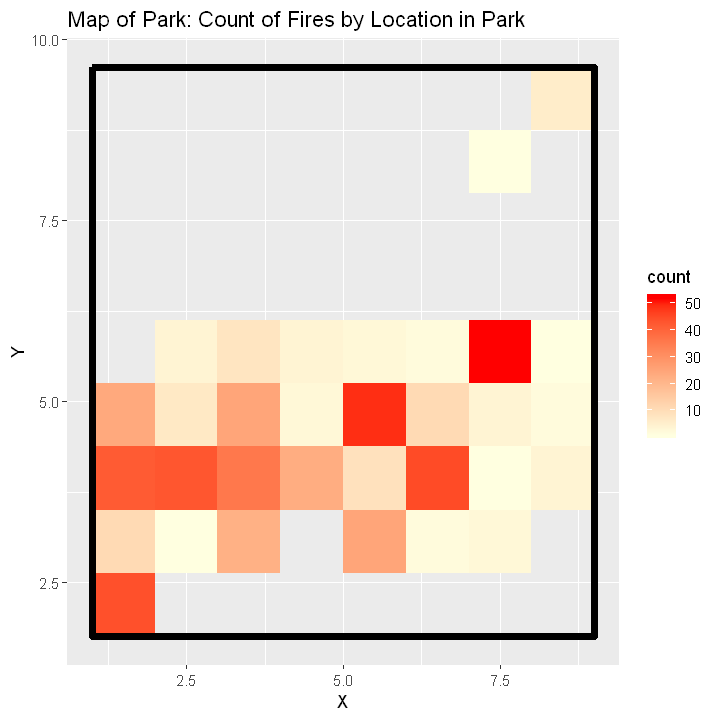

In [118]:
ggplot(ff, aes(x=X, y=Y)) + 
  geom_bin2d(bins=8) + 
  scale_fill_gradient(low= "light yellow", high="Red") +
  geom_rect(xmin=1, xmax=9, ymin=1.75, ymax=9.625, color="black", fill=NA, size=2) +
  ggtitle("Map of Park: Count of Fires by Location in Park")

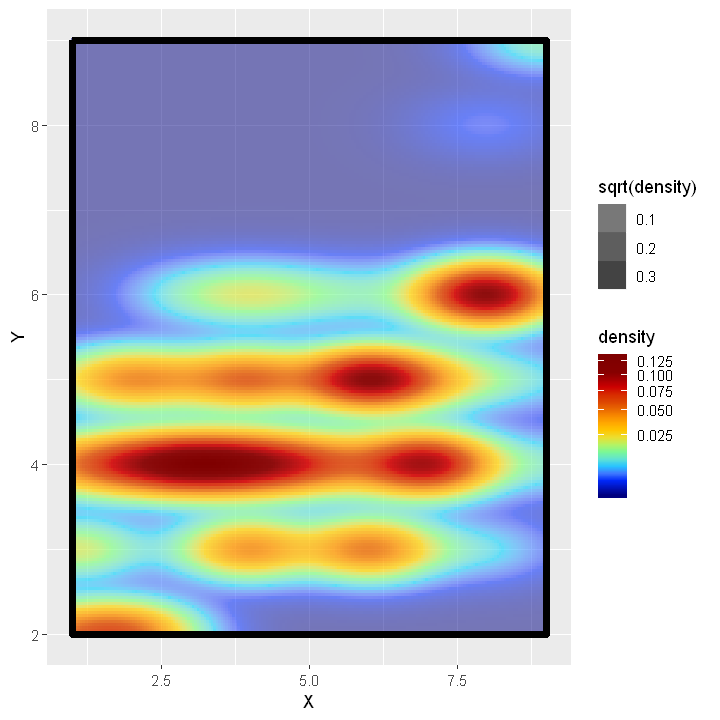

In [119]:
jet.colors <- colorRampPalette(c("#00007F", "blue", "#007FFF", "cyan", "#7FFF7F", "yellow", "#FF7F00", "orange", "#dd4b02", "red", "#7F0000", "dark red", "#7F0000"))

ggplot(ff, aes(X, Y)) + 
  stat_density2d(geom="tile", aes(fill=..density.., alpha=sqrt(..density..)), contour=FALSE, n=200) + 
  scale_alpha(range = c(0.5, 1.0)) + 
  scale_fill_gradientn(colours = jet.colors(10), trans="sqrt") + 
  geom_rect(xmin=1, xmax=9, ymin=2, ymax=9, color="black", fill=NA, size=2)

In [120]:
ffXYgroup = ff %>%
    group_by(X, Y) %>%
    summarize(logMeanArea = log(mean(area)), meanArea = mean(area), medianArea = median(area), count = length(area), totalArea = sum(area), maxArea = max(area))
ffXYgroup[ffXYgroup==-Inf] <- 0
ffXYgroup

X,Y,logMeanArea,meanArea,medianArea,count,totalArea,maxArea
1,2,2.4489158,11.5757895,0.000,19,219.94,212.88
1,3,2.7545520,15.7140000,3.025,10,157.14,70.76
1,4,2.3044500,10.0186667,3.500,15,150.28,82.75
1,5,3.3627164,28.8675000,9.415,4,115.47,95.18
2,2,2.9180950,18.5060000,0.000,25,462.65,200.94
2,3,0.0000000,0.0000000,0.000,1,0.00,0.00
2,4,1.6695918,5.3100000,1.640,27,143.37,54.29
2,5,1.5328808,4.6315000,3.140,20,92.63,26.43
3,3,1.8840347,6.5800000,6.580,1,6.58,6.58
3,4,1.0778557,2.9383721,0.000,43,126.35,35.88


We need to use the logArea in this next graph due to the outlier at 8,8.  There is only one fire there and it is massive, which throws everything else off.

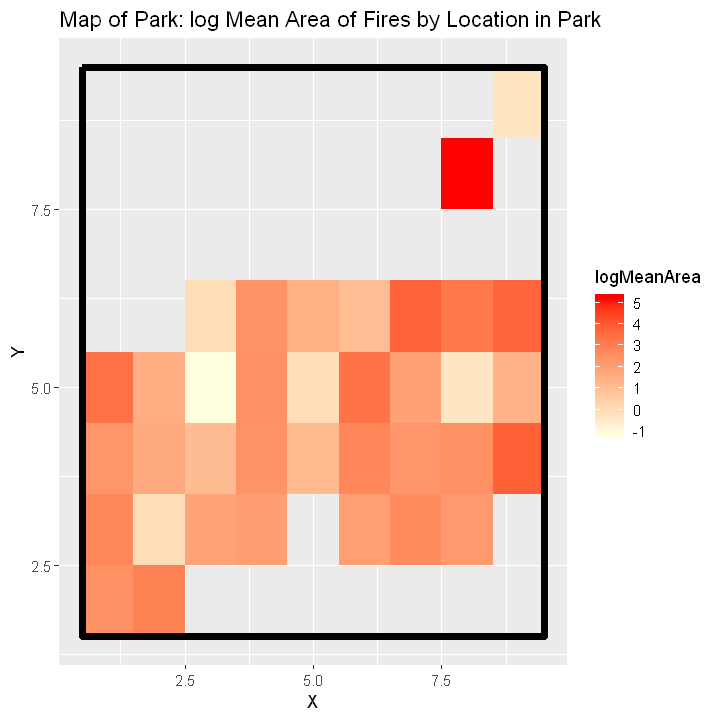

In [121]:
ggplot(ffXYgroup, aes(x=X, y=Y, fill=logMeanArea)) +
  geom_tile() + 
  scale_fill_gradient(low= "light yellow", high="Red") + 
  geom_rect(xmin=0.5, xmax=9.5, ymin=1.5, ymax=9.5, color="black", fill=NA, size=2) +
  ggtitle("Map of Park: log Mean Area of Fires by Location in Park")

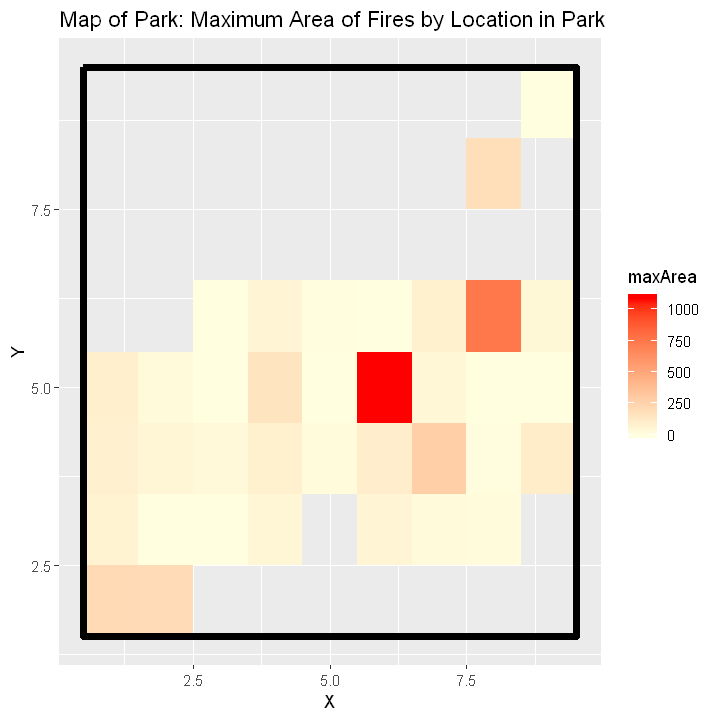

In [122]:
ggplot(ffXYgroup, aes(x=X, y=Y, fill=maxArea)) +
  geom_tile() + 
  scale_fill_gradient(low= "light yellow", high="Red") + 
  geom_rect(xmin=0.5, xmax=9.5, ymin=1.5, ymax=9.5, color="black", fill=NA, size=2) +
  ggtitle("Map of Park: Maximum Area of Fires by Location in Park")

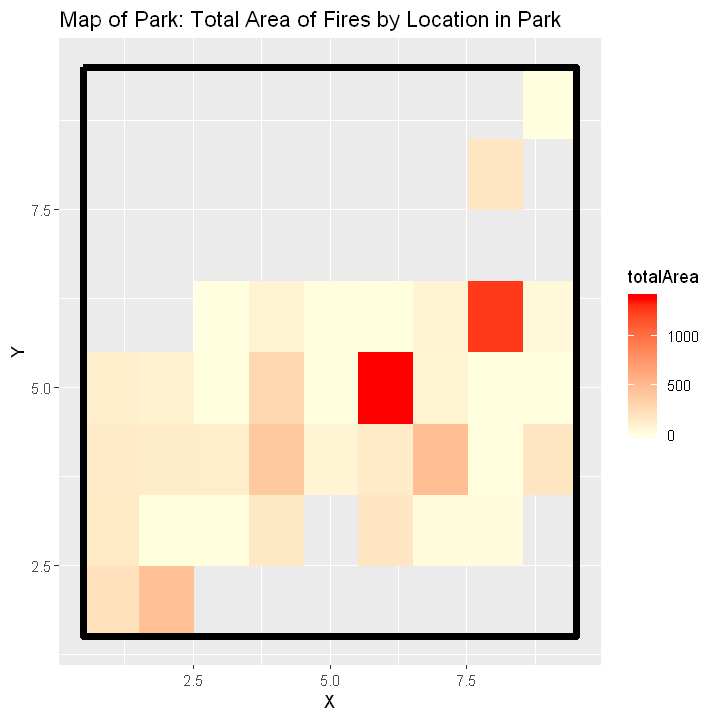

In [123]:
ggplot(ffXYgroup, aes(x=X, y=Y, fill=totalArea)) +
  geom_raster() + 
  scale_fill_gradient(low= "light yellow", high="Red") + 
  geom_rect(xmin=0.5, xmax=9.5, ymin=1.5, ymax=9.5, color="black", fill=NA, size=2) +
  ggtitle("Map of Park: Total Area of Fires by Location in Park")

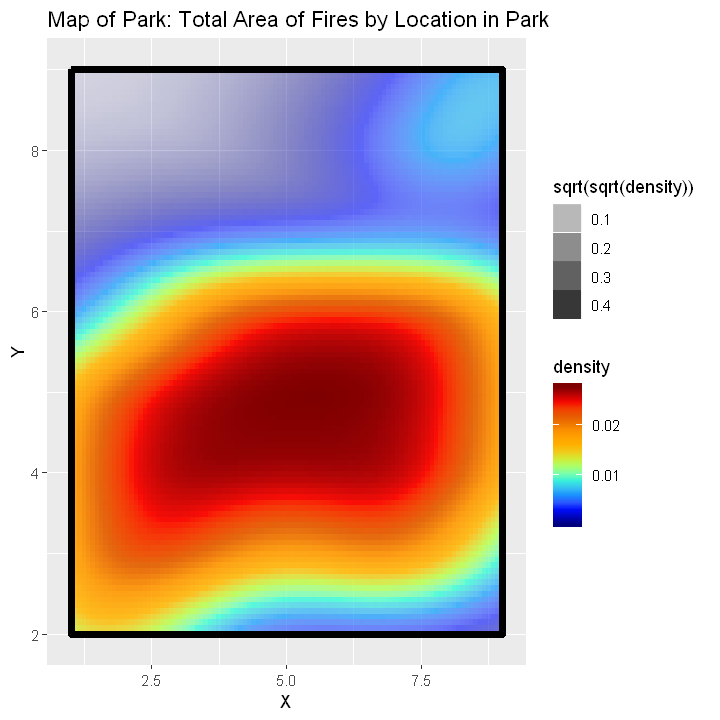

In [124]:
jet.colors <- colorRampPalette(c("#00007F", "blue", "#007FFF", "cyan", "#7FFF7F", "yellow", "#FF7F00", "orange", "#dd4b02", "red", "#7F0000"))

ggplot(ffXYgroup, aes(X, Y, density = totalArea)) + 
  stat_density_2d(geom="tile", aes(fill=..density.., alpha=sqrt(sqrt(..density..))), contour=FALSE, n=100) + 
  scale_alpha(range = c(0.1, 1.0)) + 
  scale_fill_gradientn(colours = jet.colors(10)) + 
  geom_rect(xmin=1, xmax=9, ymin=2, ymax=9, color="black", fill=NA, size=2) + 
  ggtitle("Map of Park: Total Area of Fires by Location in Park")

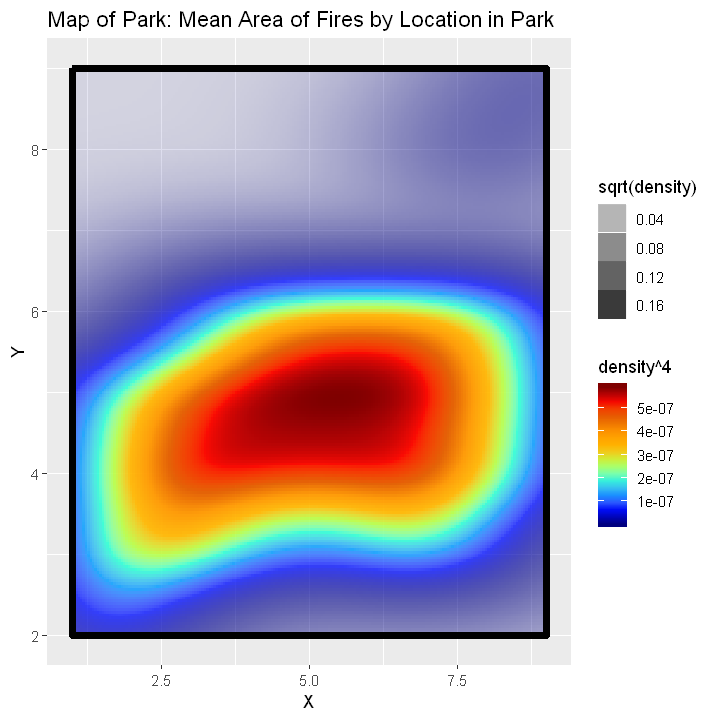

In [125]:
jet.colors <- colorRampPalette(c("#00007F", "blue", "#007FFF", "cyan", "#7FFF7F", "yellow", "#FF7F00", "orange", "#dd4b02", "red", "#7F0000"))

ggplot(ffXYgroup, aes(X, Y, density = logMeanArea)) + 
  stat_density_2d(geom="tile", aes(fill=..density..^4, alpha=sqrt(..density..)), contour=FALSE, n=200) + 
  scale_alpha(range = c(0.1, 1.0)) + 
  scale_fill_gradientn(colours = jet.colors(10)) + 
  geom_rect(xmin=1, xmax=9, ymin=2, ymax=9, color="black", fill=NA, size=2) + 
  ggtitle("Map of Park: Mean Area of Fires by Location in Park")

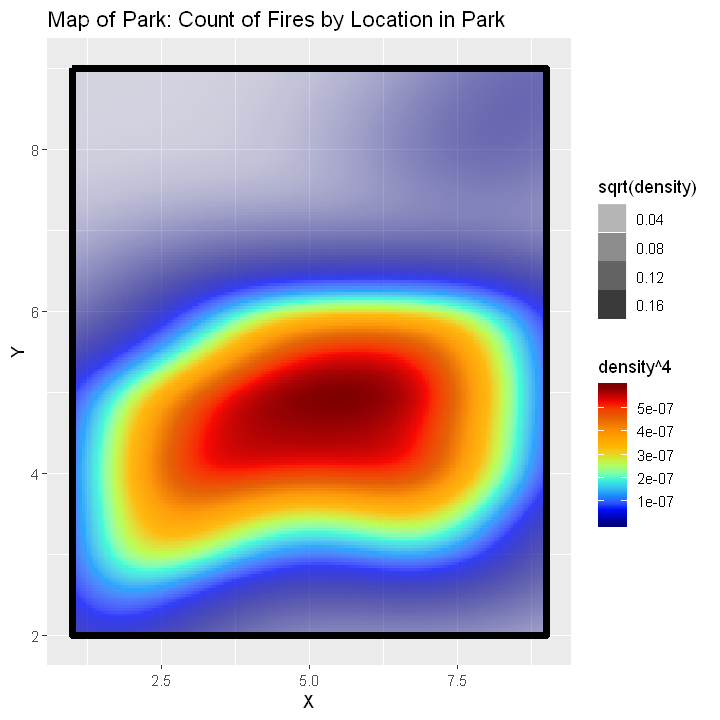

In [126]:
jet.colors <- colorRampPalette(c("#00007F", "blue", "#007FFF", "cyan", "#7FFF7F", "yellow", "#FF7F00", "orange", "#dd4b02", "red", "#7F0000"))

ggplot(ffXYgroup, aes(X, Y, density = count)) + 
  stat_density_2d(geom="tile", aes(fill=..density..^4, alpha=sqrt(..density..)), contour=FALSE, n=200) + 
  scale_alpha(range = c(0.1, 1.0)) + 
  scale_fill_gradientn(colours = jet.colors(10)) + 
  geom_rect(xmin=1, xmax=9, ymin=2, ymax=9, color="black", fill=NA, size=2) + 
  ggtitle("Map of Park: Count of Fires by Location in Park")

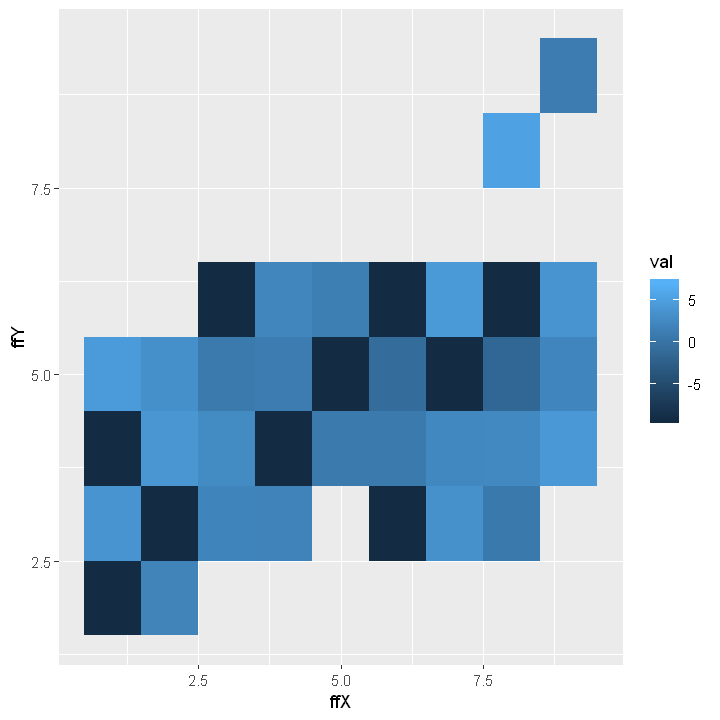

In [127]:
m= matrix( rep( 0, len=max(ff$X)*max(ff$Y)), nrow = max(ff$X))
ffX=ff$X
ffY=ff$Y
val=log(ff$area+0.0001)
dframe_XYarea = data.frame(ffX,ffY,val)
library(ggplot2)

ggplot(data = dframe_XYarea, aes(x=ffX, y=ffY, fill=val)) + 
  geom_tile()
    
#image(m, axes = FALSE, col = grey(seq(0, 1, length = 256)))

#### Month/Area and Month/Temp

In [128]:
bff %>%
    group_by(month) %>%
    summarize(count = length(area), mean(area), maxar = max(area), maxt = max(temp), meant = mean(temp),
    median(area), sum(area)) %>%
    arrange(desc(maxar))
          

month,count,mean(area),maxar,maxt,meant,median(area),sum(area)
sep,39,73.72872,1090.84,28.3,20.06923,29.480,2875.42
aug,30,69.16367,746.28,33.3,22.42000,27.585,2074.91
jul,3,134.00000,278.53,26.9,20.96667,86.450,402.00
jun,2,40.20000,70.32,26.4,25.45000,40.200,80.40
apr,2,36.03000,61.13,13.7,9.75000,36.030,72.06
feb,3,29.69000,51.78,10.1,8.80000,24.240,89.07
oct,3,29.10000,49.37,20.2,18.23333,24.230,87.30
may,1,38.48000,38.48,18.0,18.00000,38.480,38.48
mar,7,25.63857,36.85,17.0,14.10000,28.660,179.47
dec,5,17.31400,24.77,5.1,4.80000,17.850,86.57


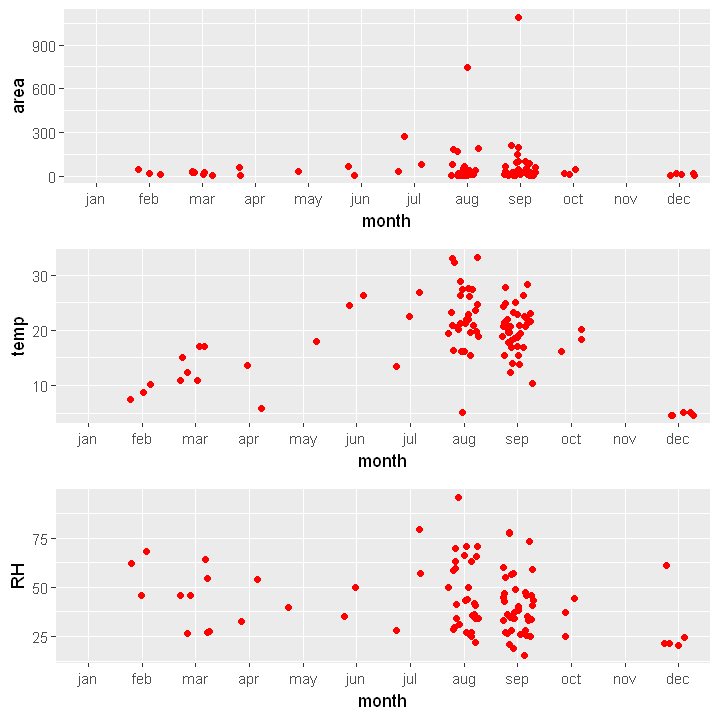

In [129]:
#Area by month
arMonth <- ggplot()+
geom_jitter(aes(month, area), data = bff, colour = I("red"), position = position_jitter(width = 0.3)) +
scale_x_discrete(limits=c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"))

#Temp by month
tempMonth <- ggplot()+
geom_jitter(aes(month, temp), data = bff, colour = I("red"), position = position_jitter(width = 0.3)) +
 scale_x_discrete(limits=c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"))

#Temp by rh
rhMonth <- ggplot()+
geom_jitter(aes(month, RH), data = bff, colour = I("red"), position = position_jitter(width = 0.3)) +
 scale_x_discrete(limits=c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"))

ggarrange(arMonth, tempMonth, rhMonth,
          ncol = 1, nrow = 3)

#### FFMC (Fine Fuel Moisture Code)

In [130]:
summary(ff$FFMC)
sd(ff$FFMC)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.70   90.20   91.60   90.64   92.90   96.20 

[1] 5.520111

What we notice from the summary is that the data is fairly compact, it only has a standard deviation of 5.5.  Unfortunately we don't know the units of this variable, but we can tell that most fires occur with a very high FFMC.

In [131]:
summary(bff$FFMC)
sd(bff$FFMC)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  63.50   90.40   91.60   90.82   93.05   96.10 

[1] 4.310296

What I see here is that when we remove all of the small fires (less than ten hectares), we remove most of the outliers.  This signals to me, that a very low FFMC may indicate a small fire.

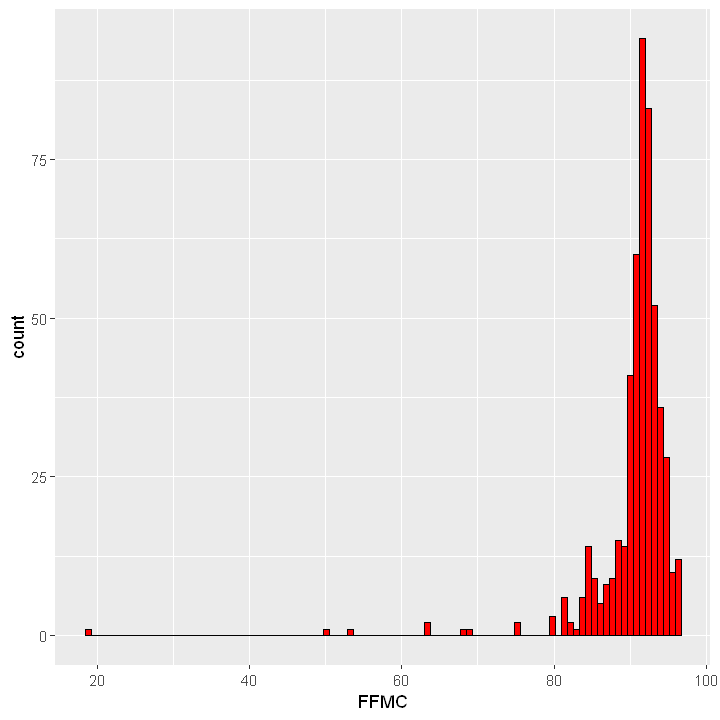

In [132]:
ggplot(ff, aes(x=FFMC)) +
  geom_histogram(bins=100, color="black", fill="red")

Looking at the histogram we confirm what we saw in the summary, the data is very heavily left skewed.  I want to dive into the outliers.

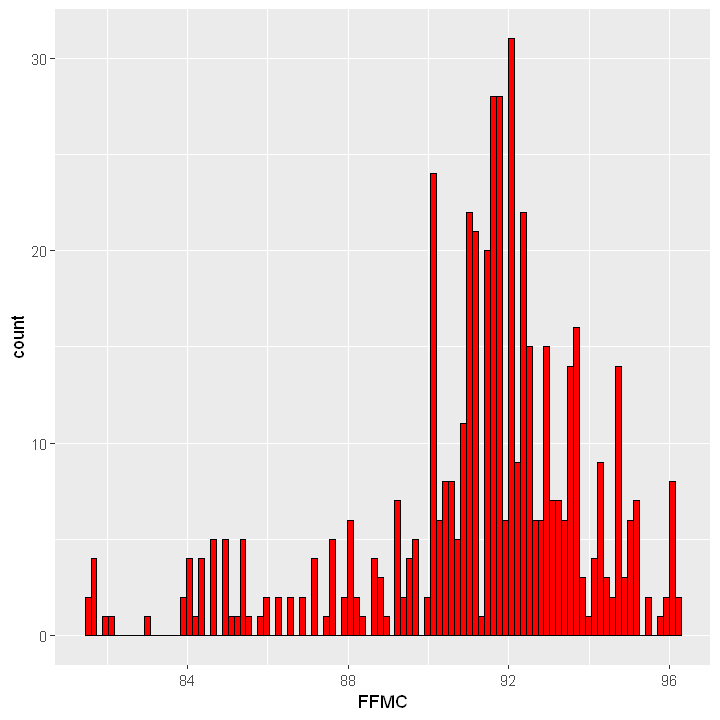

In [133]:
#look at data within 2 std 
ffFFMCusual = ff[ff$FFMC > mean(ff$FFMC) - 2*sd(ff$FFMC) & ff$FFMC < mean(ff$FFMC) + 2*sd(ff$FFMC),]
ggplot(ffFFMCusual, aes(x=FFMC)) +
  geom_histogram(bins=100, color="black", fill="red")

Zooming in on the usual values (within 2 standard deviations) we see that it is still slightly left skewed.

In [134]:
#Looking at the left side outliers
ff[ff$FFMC < mean(ff$FFMC) - 2*sd(ff$FFMC),]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
13,6,5,aug,fri,63.5,70.8,665.3,0.8,17.0,72,6.7,0,0.00
41,4,4,jul,tue,79.5,60.6,366.7,1.5,23.3,37,3.1,0,0.00
98,3,4,mar,sat,69.0,2.4,15.5,0.7,17.4,24,5.4,0,0.00
131,4,6,feb,sat,68.2,21.5,87.2,0.8,15.4,40,2.7,0,0.00
200,2,4,sep,mon,63.5,70.8,665.3,0.8,22.6,38,3.6,0,11.32
300,6,5,jun,sat,53.4,71.0,233.8,0.4,10.6,90,2.7,0,0.00
313,2,4,sep,sun,50.4,46.2,706.6,0.4,12.2,78,6.3,0,0.00
380,4,5,jan,sun,18.7,1.1,171.4,0.0,5.2,100,0.9,0,0.00
464,6,5,feb,tue,75.1,4.4,16.2,1.9,4.6,82,6.3,0,5.39
465,6,4,feb,tue,75.1,4.4,16.2,1.9,5.1,77,5.4,0,2.14


Looking at the breakdown of the low outliers, I look more at the area statistics since that is what we care about.  I notice that the areas are all very small.  The largest fire seen in this group is still below the average fire size of about 12 hectares.

#### DC (Drought Code)

In [135]:
summary(ff$DC)
sd(ff$DC)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    7.9   437.7   664.2   547.9   713.9   860.6 

[1] 248.0662

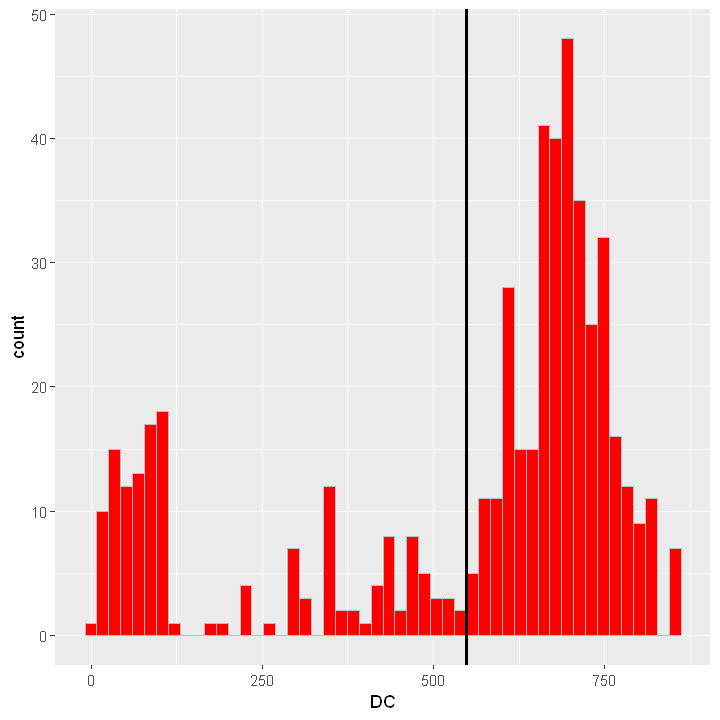

In [136]:
ggplot(ff, aes(x=DC)) +
  geom_histogram(bins=50, color="gray", fill="red") +
  geom_vline(aes(xintercept = mean(ff$DC)), colour="black", size = 1)

Here we notice that the data is fairly bimodal, and has a decently size left skew.  It will be interesting to look into the different types of fires that each clump represents.  Splitting based on the mean could give us a decent grasp of that.  

#### DMC (Duff Moisture Code)

In [137]:
summary(ff$DMC)
dmcMean = mean(ff$DMC)
dmcSD = sd(ff$DMC)
dmcSD

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.1    68.6   108.3   110.9   142.4   291.3 

[1] 64.04648

First thing I notice is that there is a massive range in these values, from 1.1 to 291.3.  The mean is also at around 1/3 of the total range.

# _This is an option for how we represent our histograms, colorized and has the standard deviations super imposed.  Something to think about._

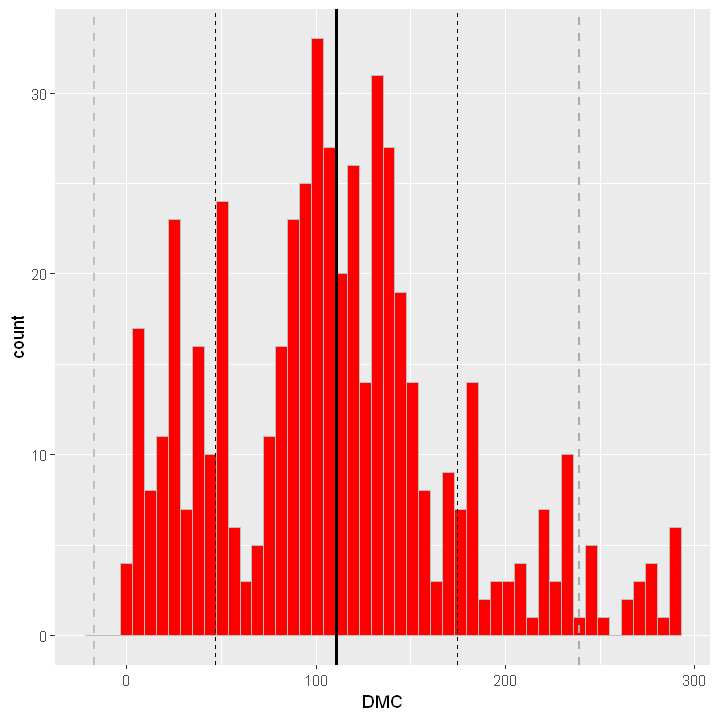

In [138]:
ggplot(ff, aes(x=DMC)) +
  geom_histogram(bins=50, fill="red", color="gray") + 
  geom_vline(aes(xintercept = dmcMean), colour="black", size = 1) + 
  geom_vline(aes(xintercept = dmcMean-dmcSD), colour="black", size = 0.5, linetype="dashed") + 
  geom_vline(aes(xintercept = dmcMean+dmcSD), colour="black", size = 0.5, linetype="dashed") + 
  geom_vline(aes(xintercept = dmcMean-2*dmcSD), colour="gray", size = 0.75, linetype="dashed") + 
  geom_vline(aes(xintercept = dmcMean+2*dmcSD), colour="darkgray", size = 0.75, linetype="dashed")

All things considered this looks like fairly well distributed data.  Yes there is a massive range, but there are no major outliers.  There is a very slight right skew.  Also there is a lot of granularity in the data as it goes down to the tenth.

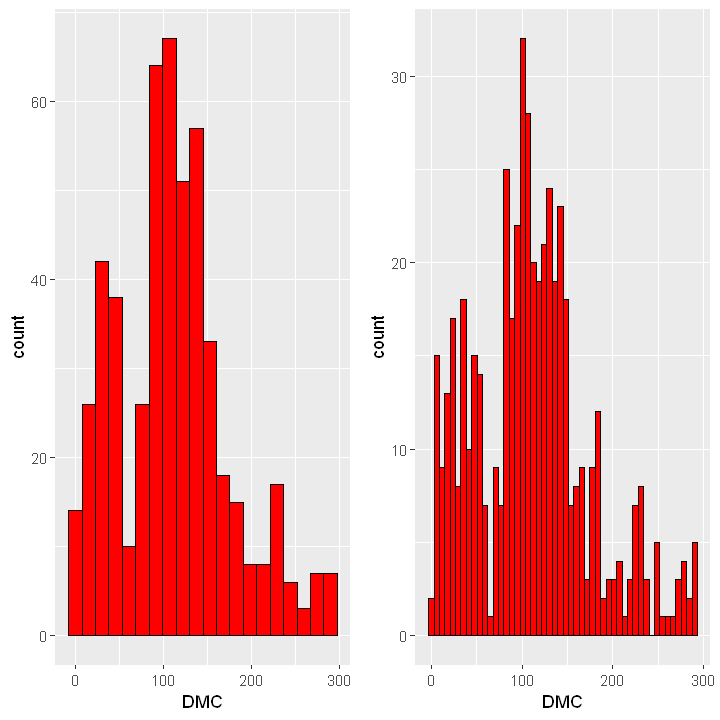

In [139]:
dmc20 = ggplot(ff, aes(x=DMC)) +
  geom_histogram(bins=20, color="black", fill="red")
dmc50 = ggplot(ff, aes(x=DMC)) +
  geom_histogram(bins=50, color="black", fill="red")
grid.arrange(dmc20, dmc50, nrow=1)

#### ISI (Initial Spread Index)

In [140]:
summary(ff$ISI)
ISIMean = mean(ff$ISI)
ISISD = sd(ff$ISI)
ISISD

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   6.500   8.400   9.022  10.800  56.100 

[1] 4.559477

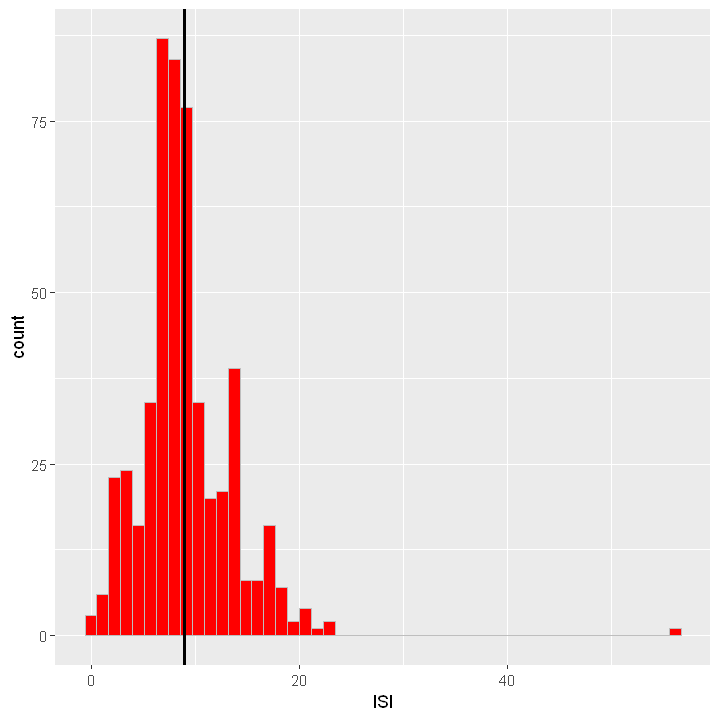

In [141]:
ggplot(ff, aes(x=ISI)) +
  geom_histogram(bins=50, color="gray", fill="red") +
  geom_vline(aes(xintercept = ISIMean), colour="black", size = 1)

ISI seems to behave very well, except for one very high outlier. I want to take a look at it.

In [142]:
ff[ff$ISI > 30,]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
23,7,4,jun,sun,94.3,96.3,200,56.1,21,44,4.5,0,0


There doesn't seem to be too much odd about this data point. The FFMC, DMC, and DC are in normal limits. The temp is barely elevated. The area is marked as 0 as well. The only thing remarkable about this point is the extremely high ISI. If I understand the Initial Spread Index correctly, this was a fire that spread extremely rapidly, but was put out before it grew at all.

In [143]:
ff[order(ff$ISI)[1:10],]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
380,4,5,jan,sun,18.7,1.1,171.4,0.0,5.2,100,0.9,0,0.00
300,6,5,jun,sat,53.4,71.0,233.8,0.4,10.6,90,2.7,0,0.00
313,2,4,sep,sun,50.4,46.2,706.6,0.4,12.2,78,6.3,0,0.00
98,3,4,mar,sat,69.0,2.4,15.5,0.7,17.4,24,5.4,0,0.00
13,6,5,aug,fri,63.5,70.8,665.3,0.8,17.0,72,6.7,0,0.00
131,4,6,feb,sat,68.2,21.5,87.2,0.8,15.4,40,2.7,0,0.00
200,2,4,sep,mon,63.5,70.8,665.3,0.8,22.6,38,3.6,0,11.32
517,6,3,nov,tue,79.5,3.0,106.7,1.1,11.8,31,4.5,0,0.00
41,4,4,jul,tue,79.5,60.6,366.7,1.5,23.3,37,3.1,0,0.00
466,2,2,feb,sat,79.5,3.6,15.3,1.8,4.6,59,0.9,0,6.84


Here are the 10 smallest ISI fires. They don't appear to have much in common. DMC and DC appear to be all over the place. I do see that they tend to have lower temperatures, and be on the low end of the FFMC scale. They also have a disproportionate grouping of 0 area fires.

#### Temperature

In [144]:
summary(ff$temp)
tempMean = mean(ff$temp)
tempSD = sd(ff$temp)
tempSD

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.20   15.50   19.30   18.89   22.80   33.30 

[1] 5.806625

Seems like a decent range, although it covers almost every temperature from 100\*F to freezing.  One thing to look at if temperature has a direct effect on fires.

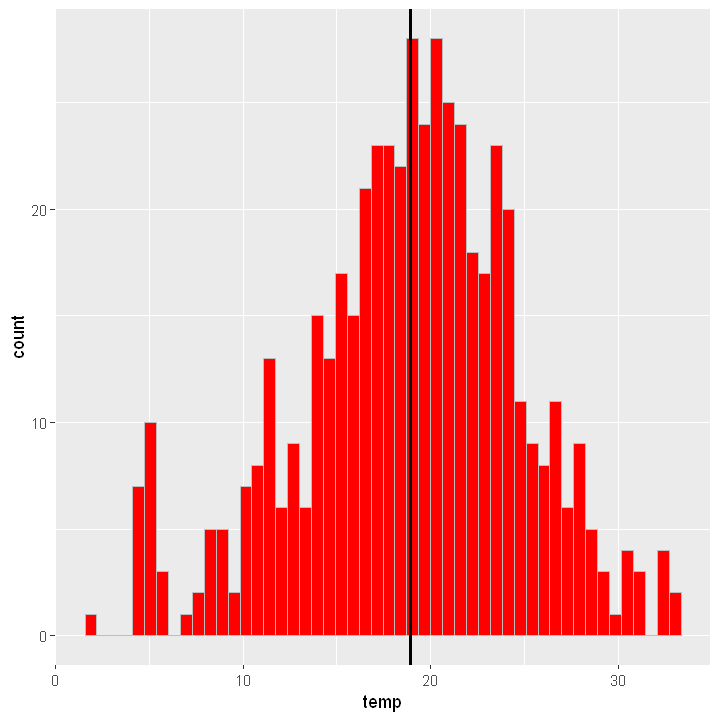

In [145]:
ggplot(ff, aes(x=temp)) +
  geom_histogram(bins=50, color="gray", fill="red") +
  geom_vline(aes(xintercept = tempMean), colour="black", size = 1)

This data is remarkably well distribued, with the average just slightly below room temperature.  I am going to convert it to farenhight to make it slightly easier to understand for us Americans.

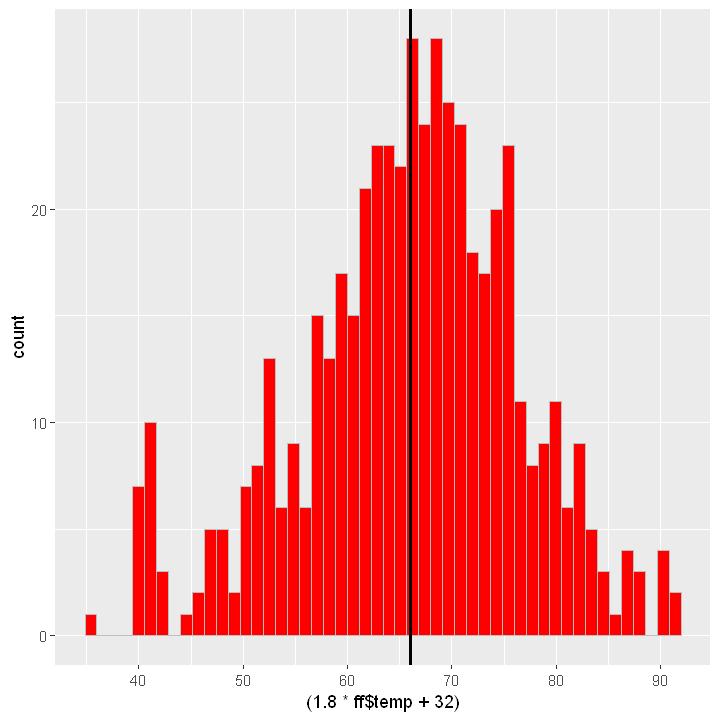

In [146]:
ggplot(ff, aes(x=(1.8*ff$temp +32))) +
  geom_histogram(bins=50, color="gray", fill="red") +
  geom_vline(aes(xintercept = (1.8*tempMean +32)), colour="black", size = 1)

#### Relative Humidity

#### Wind

#### Rain

## Key Relationships

# _I am putting general relationship analysis here.  We can move it to appropriate locations soon_

Warning message:
"Removed 10857 rows containing non-finite values (stat_smooth)."

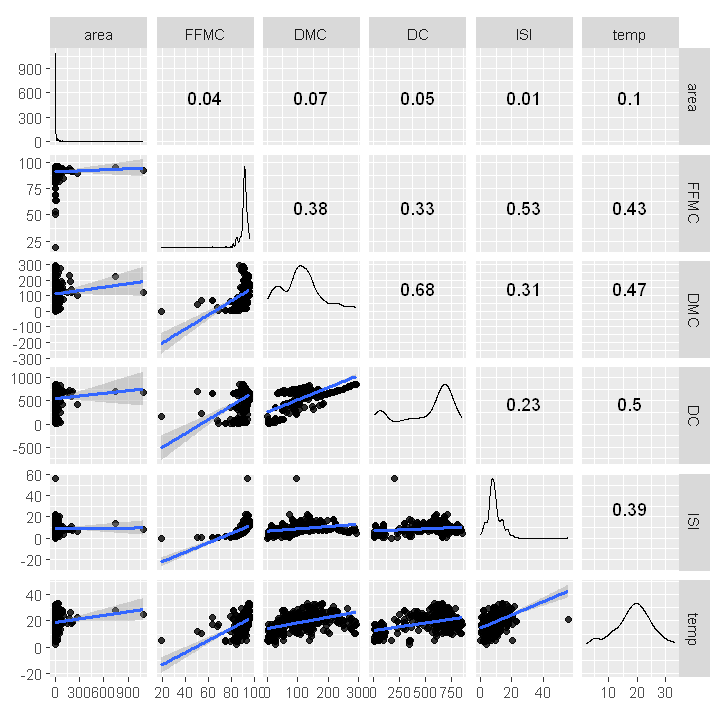

In [147]:
ggscatmat(ff[,c('area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp')], alpha=0.8) +
geom_smooth(method="lm")

There is a lot of colinearity in these variables. The highest correlation between any of the variables is between DC and DMC, with a 0.68. This means that our secondary effects write up will be full of interactions between FFMC, DMC, DC, ISI, and Temp. They are all extremely related to each other.

Warning message:
"Removed 1995 rows containing non-finite values (stat_smooth)."

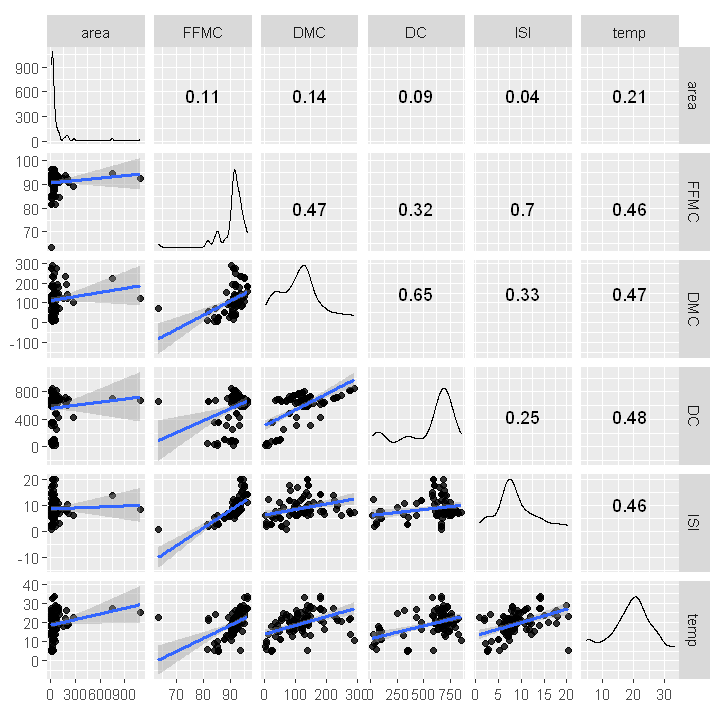

In [148]:
ggscatmat(bff[,c('area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp')], alpha=0.8) +
geom_smooth(method="lm")

Warning message:
"Removed 504 rows containing non-finite values (stat_smooth)."

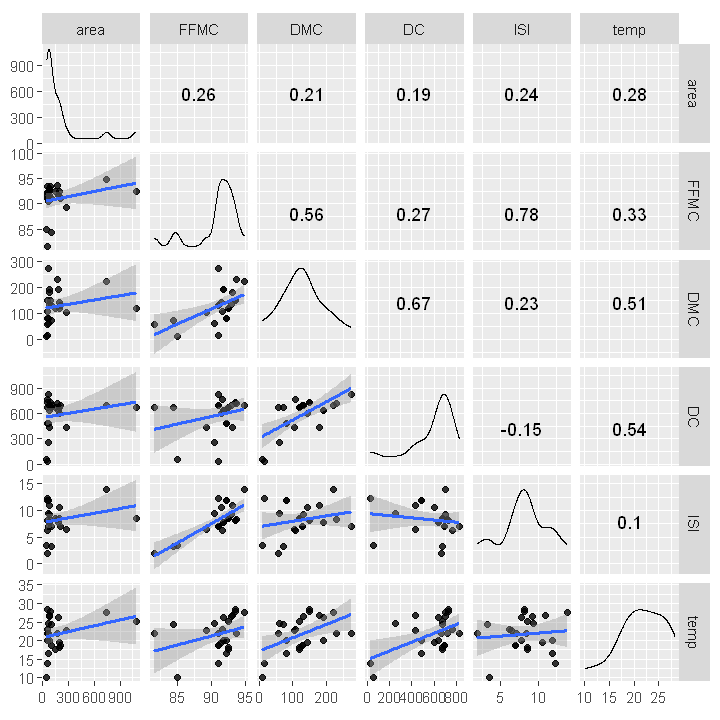

In [149]:
ggscatmat(sff[,c('area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp')], alpha=0.8) +
geom_smooth(method="lm")

Looking at only the severe fires we can see that the correlation between each variable and the severity (area) become much more pronounced, up to a 0.28 between temp and area.

Warning message:
"Removed 210 rows containing non-finite values (stat_smooth)."

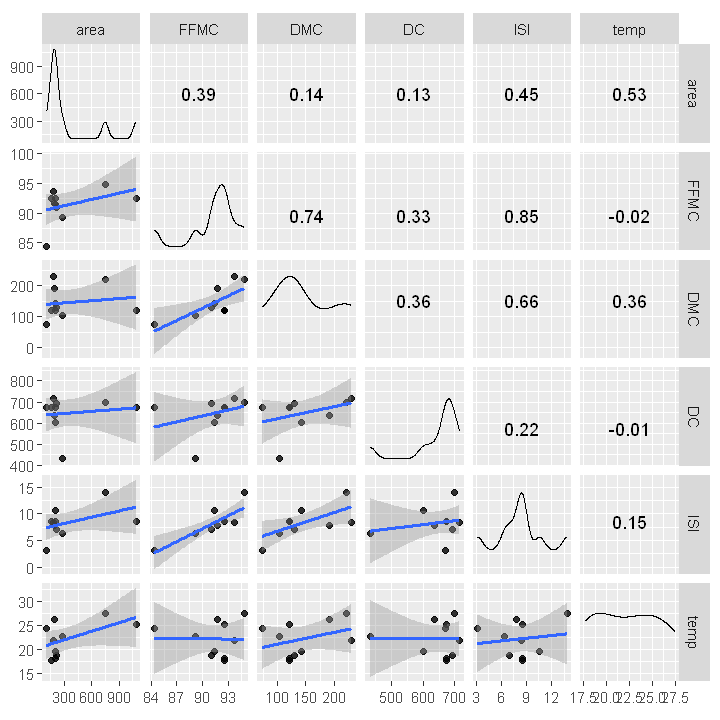

In [150]:
ggscatmat(sff[order(sff$area, decreasing=T)[1:10],c('area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp')], alpha=0.8) +
geom_smooth(method="lm")

These correlations get even stronger as we are looking at the most damaging fires. The top 10 fires in the park. Temperature and area are extremely correlated.

# _Peter: Here is your code for the key relationship stuff, Move it where you think it will fit the best_

In [151]:
# Create factor for month
off=ff[order(ff$area),]
ofmonth=factor(off$month, levels = c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep","oct", "nov", "dec"))
ofday=factor(off$day, levels = c("mon", "tue", "wed", "thu", "fri", "sat", "sun"))

# Entire data
oRH=off$RH
oTemp=off$temp
oArea=off$area
oLogArea=log(off$area+1)

oFFMC=off$FFMC
oDMC=off$DMC
oDC=off$DC
oISI =off$ISI

# create data frame
frame_data = data.frame(ofmonth,ofday, oArea, oLogArea, oRH, oTemp, oFFMC, oDMC, oDC, oISI)
frame_data2 = subset(frame_data, oArea>10)

### Key Area Relationships

# _Peter: you may want to make some of this stuff a function, since so much of the code is reused.  It may make the report more readable. You could arrange all those individual graph in row/column, for less scrolling. Have put an example at the top_


#### XY Coordinates

#### Month

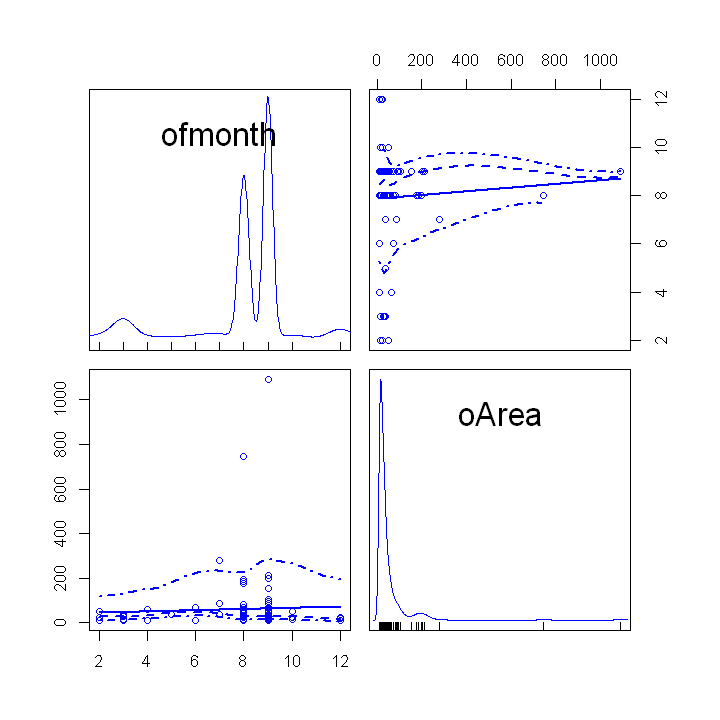

In [70]:
# 1. Bivariate relationship: month vs Area
scatterplotMatrix(~ofmonth + oArea, data=frame_data2)

#### Temperature

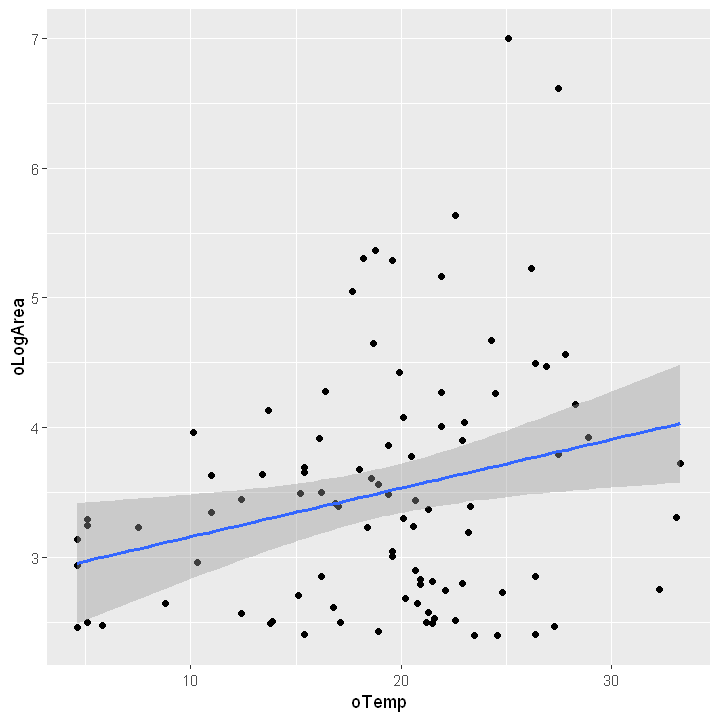

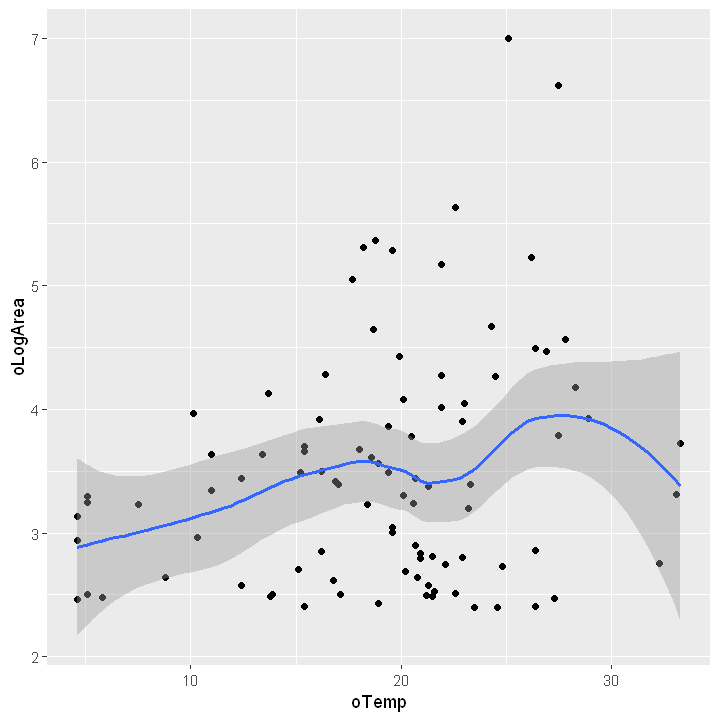

In [73]:
# 3. Bivariate relationship: temp vs Area

# plot(oTemp, oLogArea)
# m1<-lm(oLogArea ~ oTemp, data=frame_data2)
# abline(coef(m1), col = "blue")
ggplot(data=frame_data2, aes(oTemp,oLogArea))  +geom_point() + geom_smooth(method = "lm")
ggplot(data=frame_data2, aes(oTemp,oLogArea))  +geom_point() + geom_smooth(method = "loess")

Warning message:
"Removed 5 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 5 rows containing missing values (geom_point)."

Warning message:
"Removed 5 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 5 rows containing missing values (geom_point)."

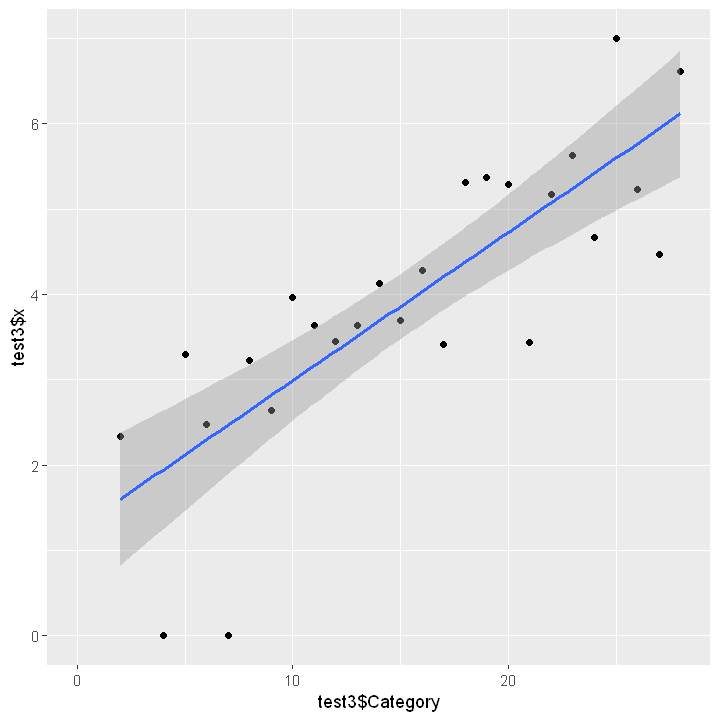

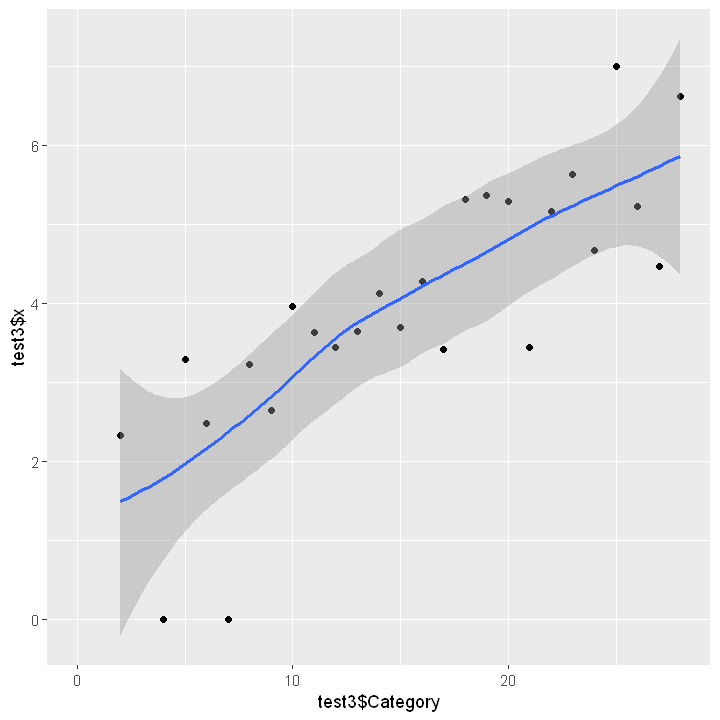

In [74]:
# grouping and choose only max value

test=data.frame(oTemp2=round(oTemp), oLogArea)
test3=aggregate(test$oLogArea, by = list(Category=test$oTemp2), max)
# plot(test3$Category, test3$x)
# m1<-lm(test3$x ~ test3$Category, data=test3)
# abline(coef(m1), col = "blue")
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="glm")+ xlim(0,28)
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="loess") + xlim(0,28)

Could visualize temperatures effect by making a stacked histogram of area, colorized by average temperature?

#### FFMC (Fine Fuel Moisture Code)

Warning message:
"Removed 7 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 7 rows containing missing values (geom_point)."Warning message:
"Removed 7 rows containing missing values (geom_point)."

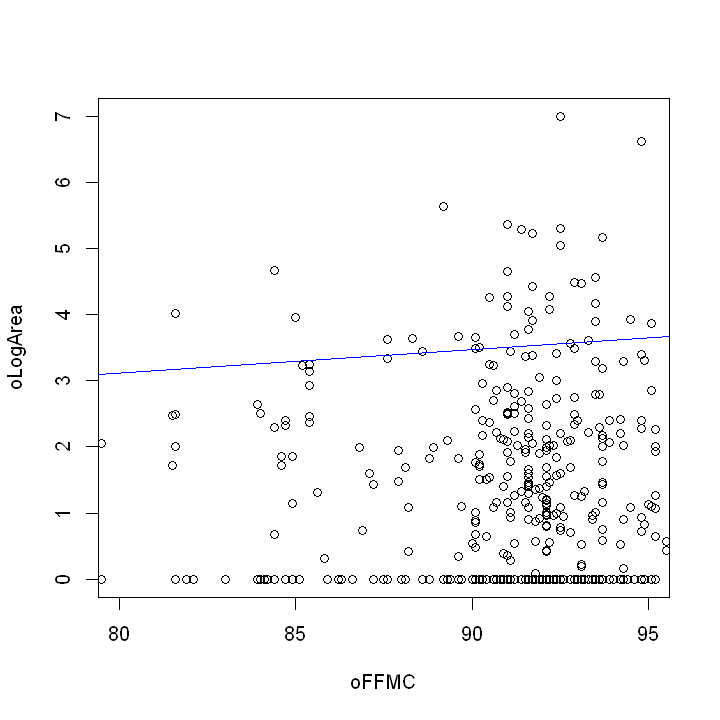

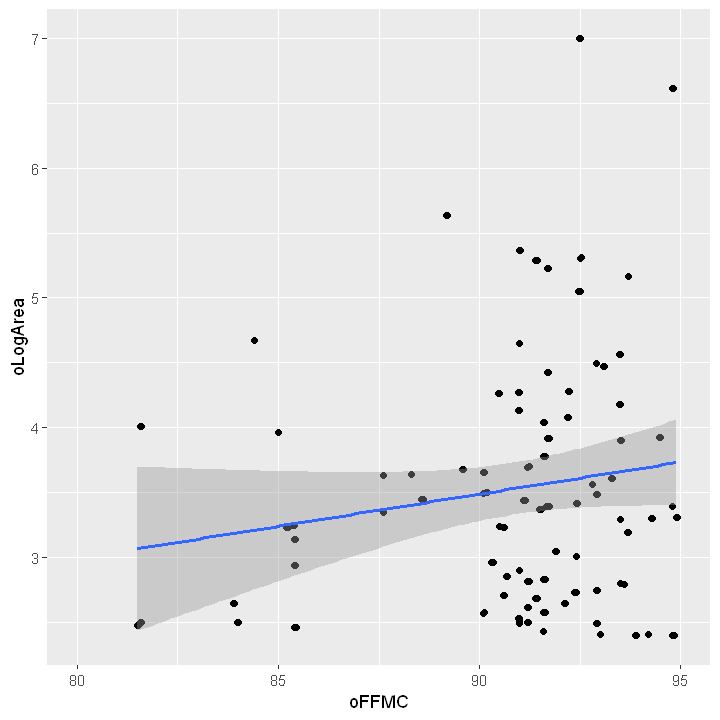

In [77]:
# 5. Bivariate relationship: FFMC vs Area
# no processing 
plot(oFFMC, oLogArea, xlim=c(80,95))
m1<-lm(oLogArea ~ oFFMC, data=frame_data2)
abline(coef(m1), col = "blue")
ggplot(data=frame_data2, aes(oFFMC,oLogArea)) +  geom_jitter() + geom_point() + geom_smooth(method = "gam") + xlim(80,95)

Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

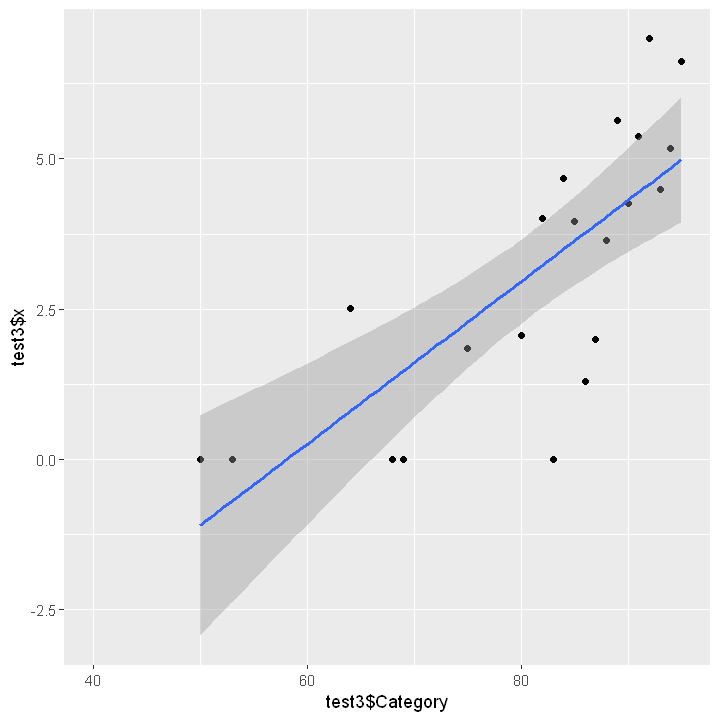

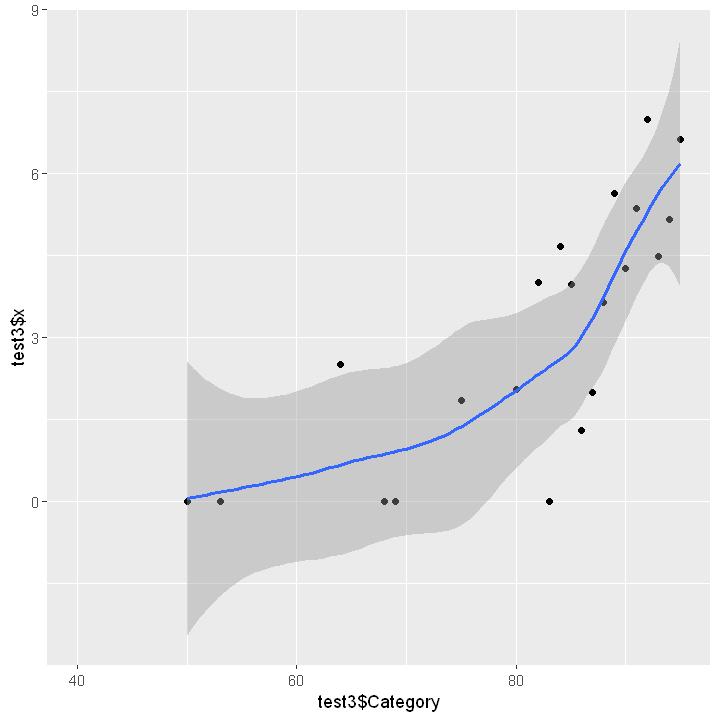

In [78]:
# grouping and choose only max value

test=data.frame(oFFMC2=round(oFFMC), oLogArea)
test3=aggregate(test$oLogArea, by = list(Category=test$oFFMC2), max)

#plot(test3$Category, test3$x)
#m1<-lm(test3$x ~ test3$Category, data=test3)
#abline(coef(m1), col = "blue")
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="lm") +xlim(40,95)
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="loess") +xlim(40,95)

#### Relative Humidity

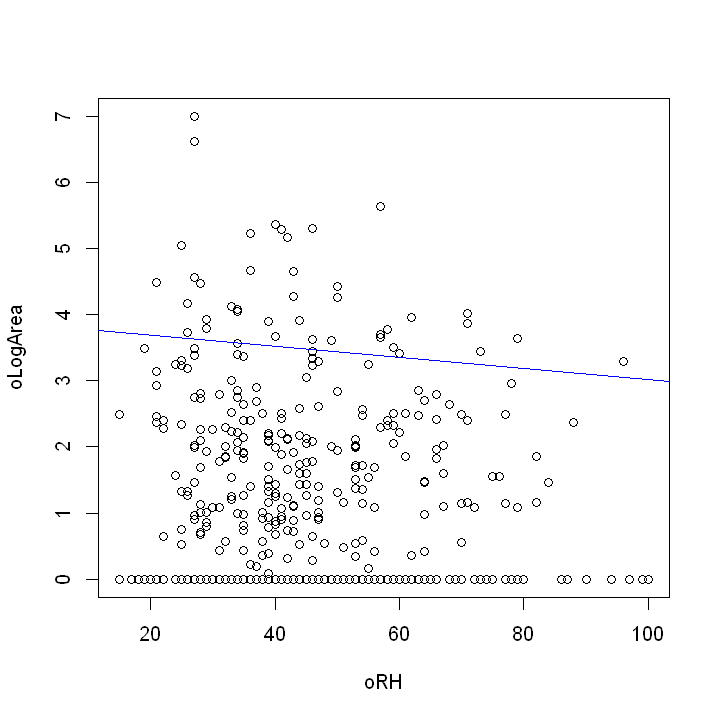

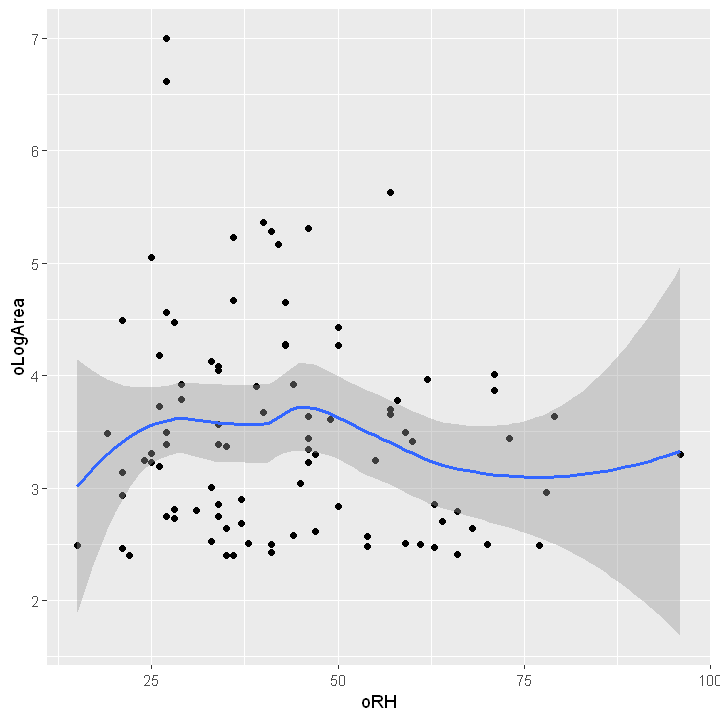

In [75]:
# 4. Bivariate relationship: RH vs Area  
# no processing

plot(oRH, oLogArea)
m1<-lm(oLogArea ~ oRH, data=frame_data2)
abline(coef(m1), col = "blue")
ggplot(data=frame_data2, aes(oRH,oLogArea)) + geom_point() + geom_smooth(method = "loess")

Warning message:
"Removed 8 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 8 rows containing missing values (geom_point)."

Warning message:
"Removed 8 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 8 rows containing missing values (geom_point)."

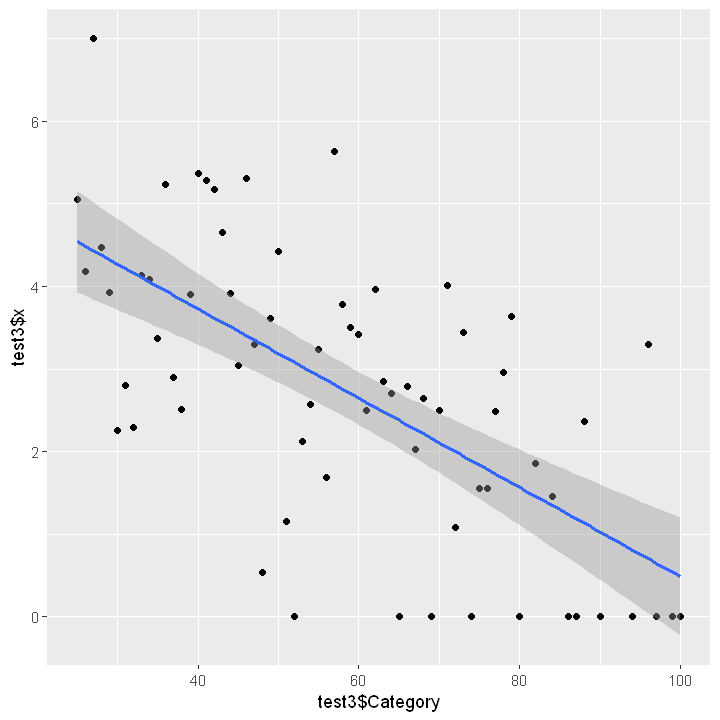

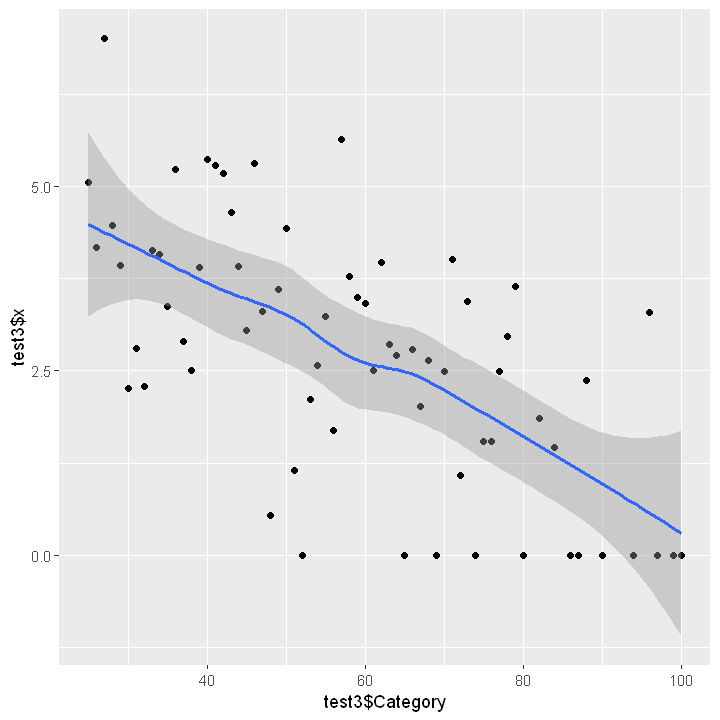

In [76]:
# grouping and choose only max value

test=data.frame(oRH2=round(oRH), oLogArea)
test3=aggregate(test$oLogArea, by = list(Category=test$oRH2), max)

# plot(test3$Category, test3$x)
# m1<-lm(test3$x ~ test3$Category, data=test3)
# abline(coef(m1), col = "blue")
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="glm")+xlim(25,100)
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="loess") +xlim(25,100)

### Secondary Area Relationships

#### Day

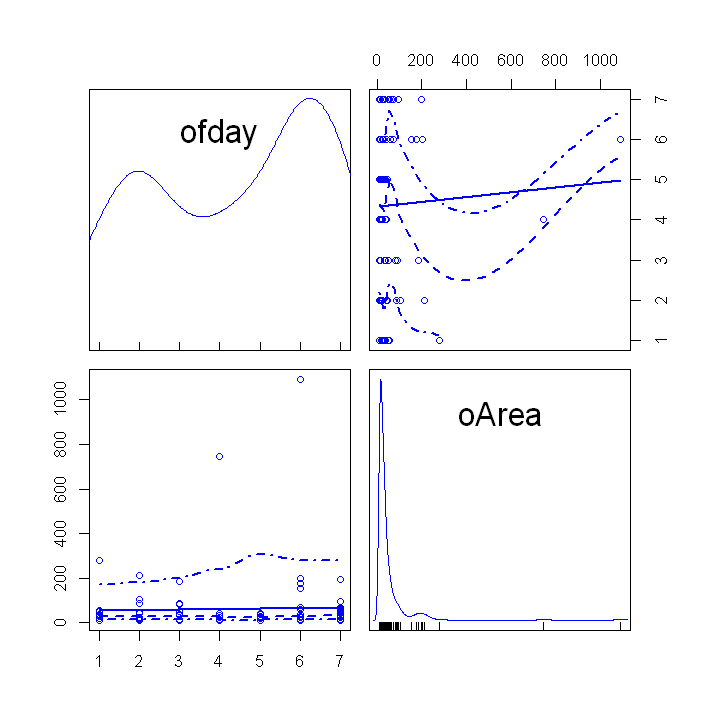

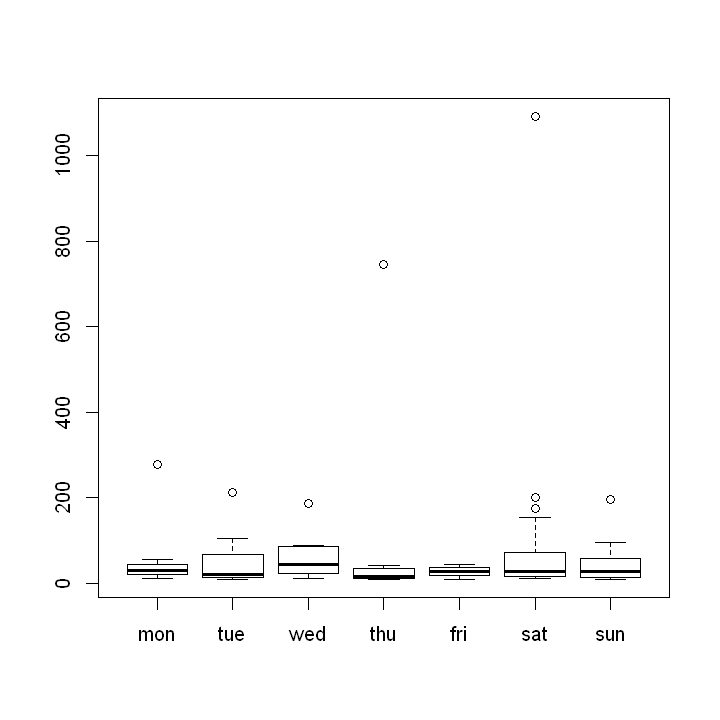

In [71]:
# 2. Bivariate relationship: day vs Area
scatterplotMatrix(~ofday + oArea, data=frame_data2)
boxplot(oArea~ofday,data=frame_data2)

#### DC (Drought Code)

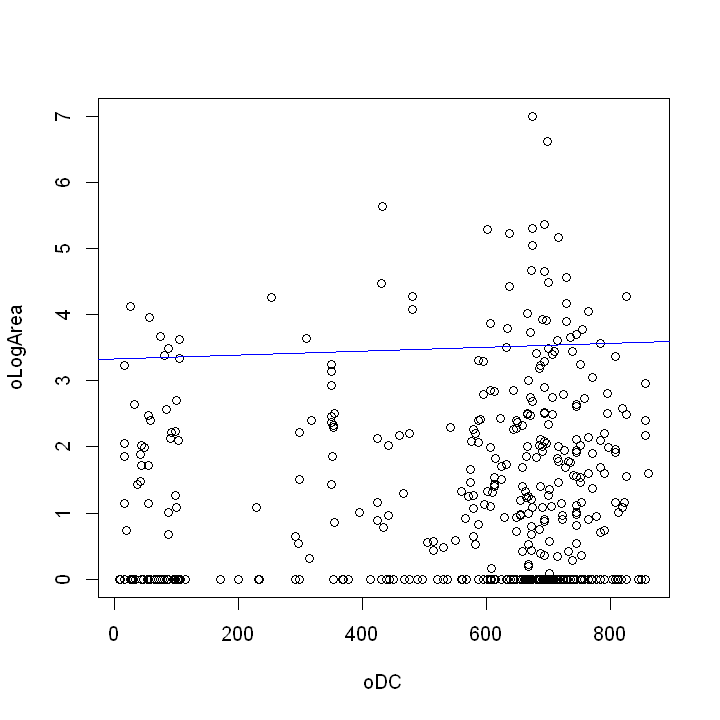

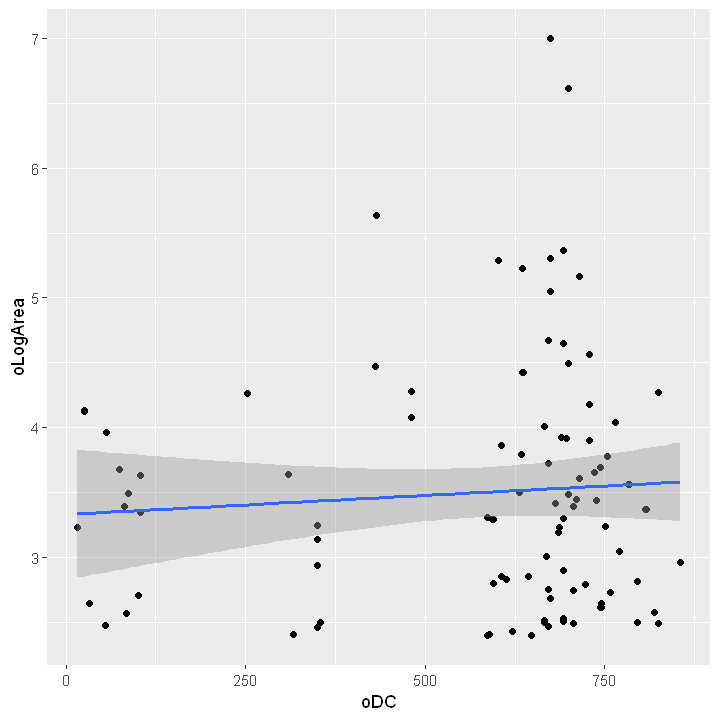

In [81]:
# 7. Bivariate relationship: DC vs Area
#frame_data = data.frame(ofmonth,ofday, oArea, oLogArea, oRH, oTemp, oFFMC, oDMC, oDC, oISI)
plot(oDC, oLogArea)
m1<-lm(oLogArea ~ oDC, data=frame_data2)
abline(coef(m1), col = "blue")
ggplot(data=frame_data2, aes(oDC,oLogArea)) + geom_jitter()+geom_point() + geom_smooth(method = "glm") 

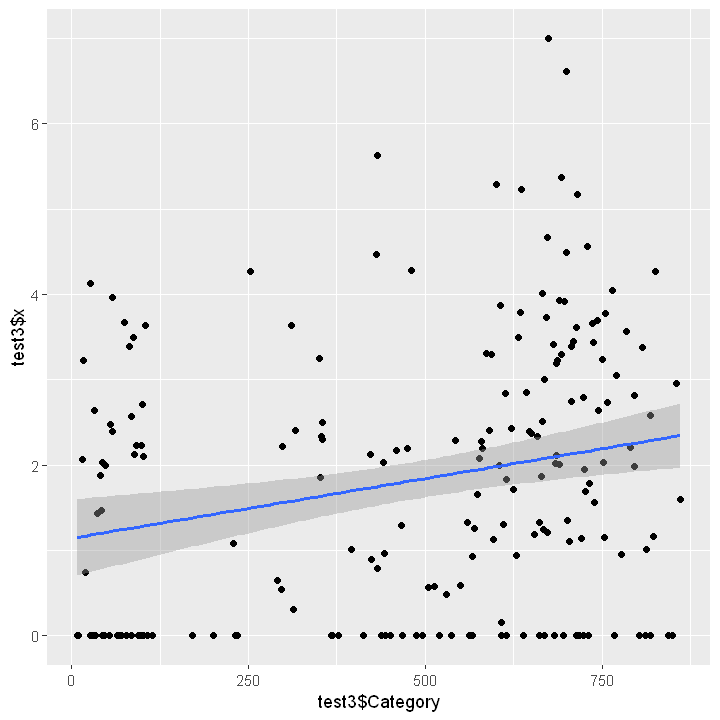

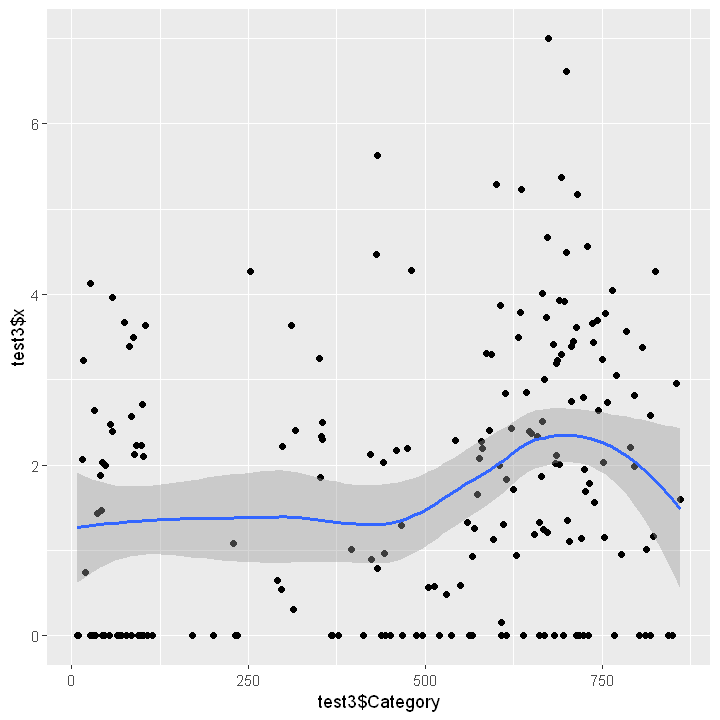

In [82]:
# grouping and choose only max value

test=data.frame(oDC2=round(oDC), oLogArea)
test3=aggregate(test$oLogArea, by = list(Category=test$oDC2), max)

#plot(test3$Category, test3$x)
#m1<-lm(test3$x ~ test3$Category, data=test3)
#abline(coef(m1), col = "blue")
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="lm") 
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="loess")

#### DMC (Duff Moisture Code)

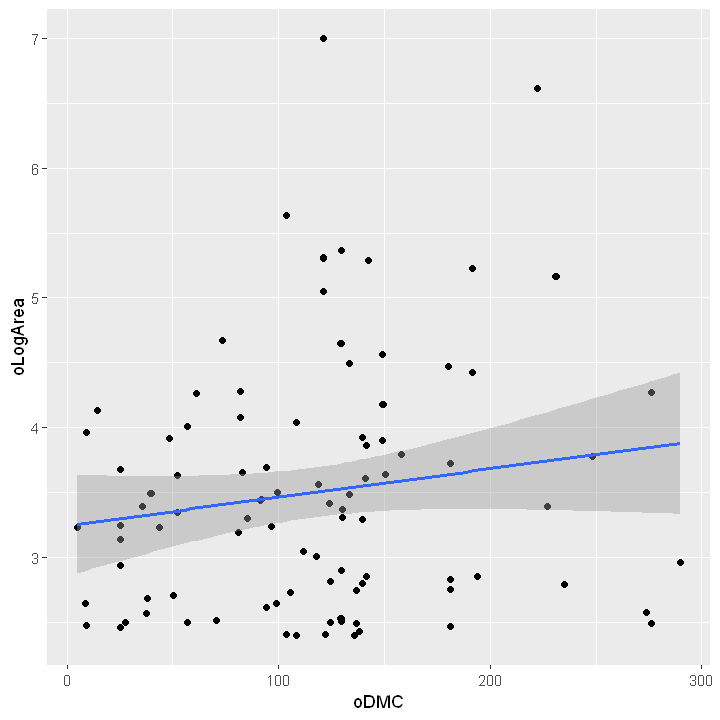

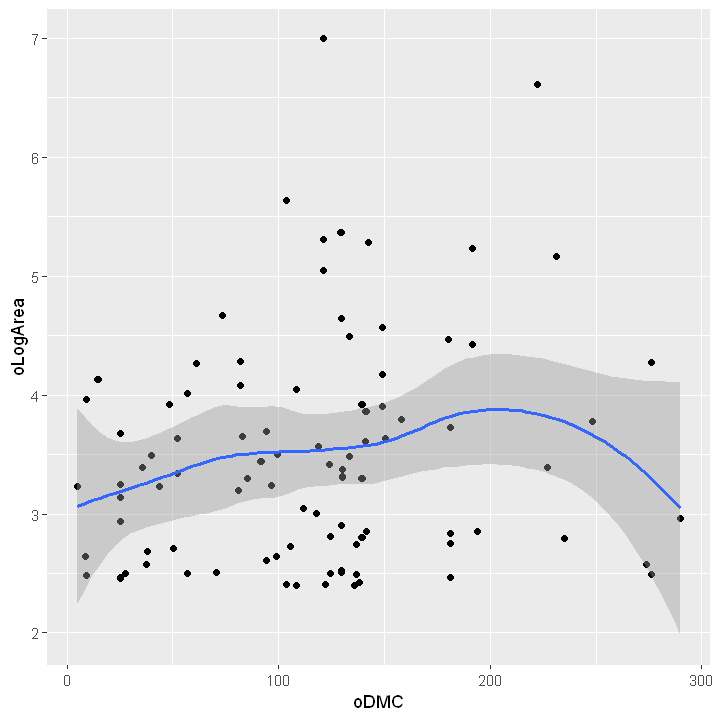

In [79]:
# 6. Bivariate relationship: DMC vs Area
#frame_data = data.frame(ofmonth,ofday, oArea, oLogArea, oRH, oTemp, oFFMC, oDMC, oDC, oISI)
# plot(oDMC, oLogArea)
# m1<-lm(oLogArea ~ oDMC, data=frame_data2)
# abline(coef(m1), col = "blue")
ggplot(data=frame_data2, aes(oDMC,oLogArea)) + geom_jitter() + geom_point() + geom_smooth(method = "lm") 
ggplot(data=frame_data2, aes(oDMC,oLogArea)) + geom_jitter() + geom_point() + geom_smooth(method = "loess") 

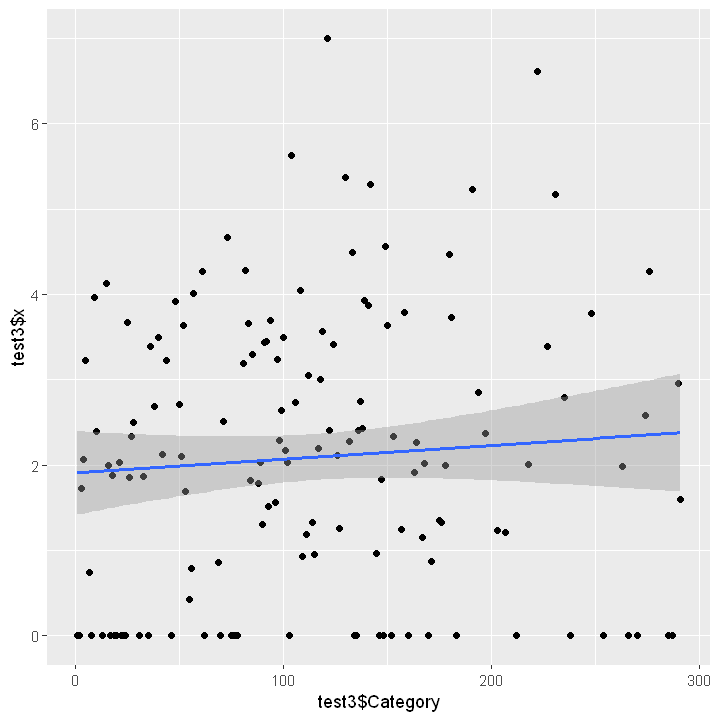

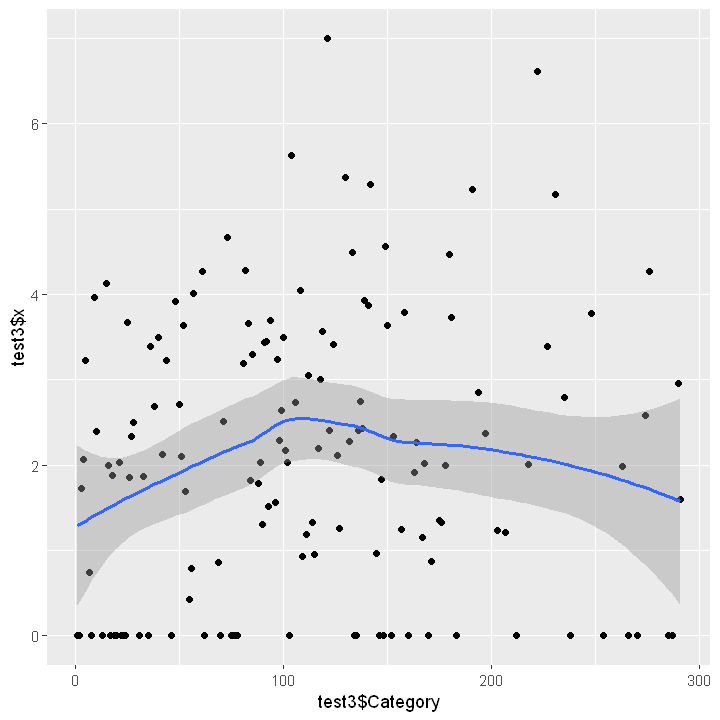

In [80]:
# grouping and choose only max value

test=data.frame(oDMC2=round(oDMC), oLogArea)
test3=aggregate(test$oLogArea, by = list(Category=test$oDMC2), max)

#plot(test3$Category, test3$x)
#m1<-lm(test3$x ~ test3$Category, data=test3)
#abline(coef(m1), col = "blue")
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="lm") 
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="loess")

### No Area Relationships

#### ISI (Initial Spread Index)

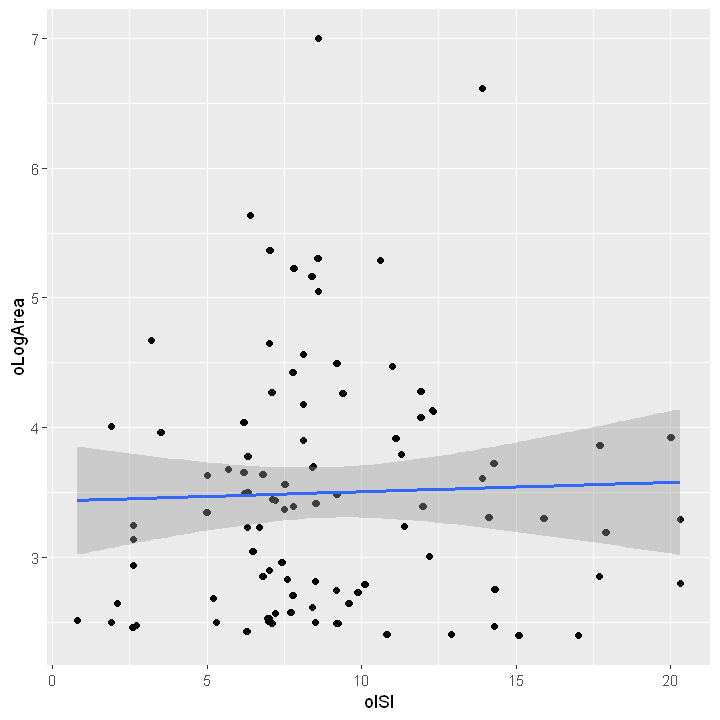

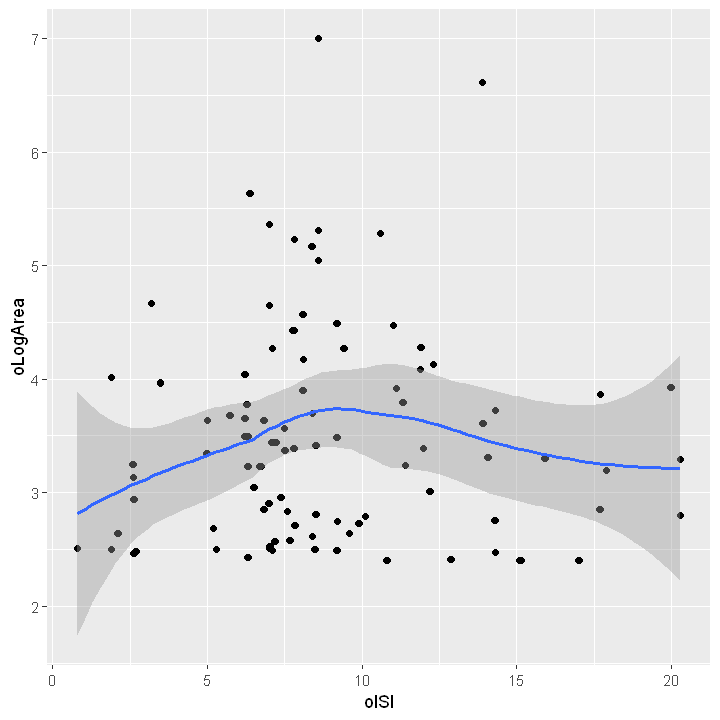

In [83]:
# 8. Bivariate relationship: ISI vs Area
#frame_data = data.frame(ofmonth,ofday, oArea, oLogArea, oRH, oTemp, oFFMC, oDMC, oDC, oISI)
# plot(oISI, oLogArea)
# m1<-lm(oLogArea ~ oISI, data=frame_data2)
# abline(coef(m1), col = "blue")
ggplot(data=frame_data2, aes(oISI,oLogArea)) + geom_jitter() +geom_point() + geom_smooth(method = "lm") 
ggplot(data=frame_data2, aes(oISI,oLogArea)) + geom_jitter() +geom_point() + geom_smooth(method = "loess") 

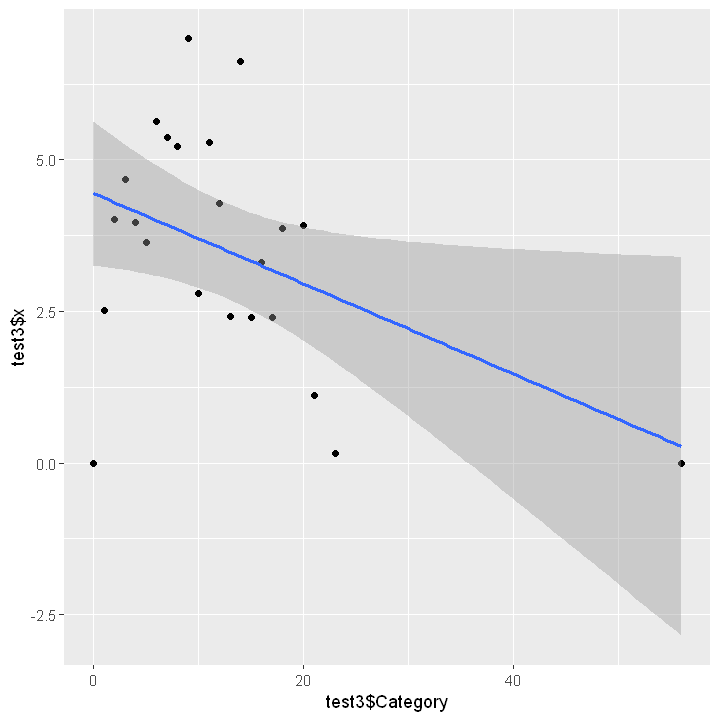

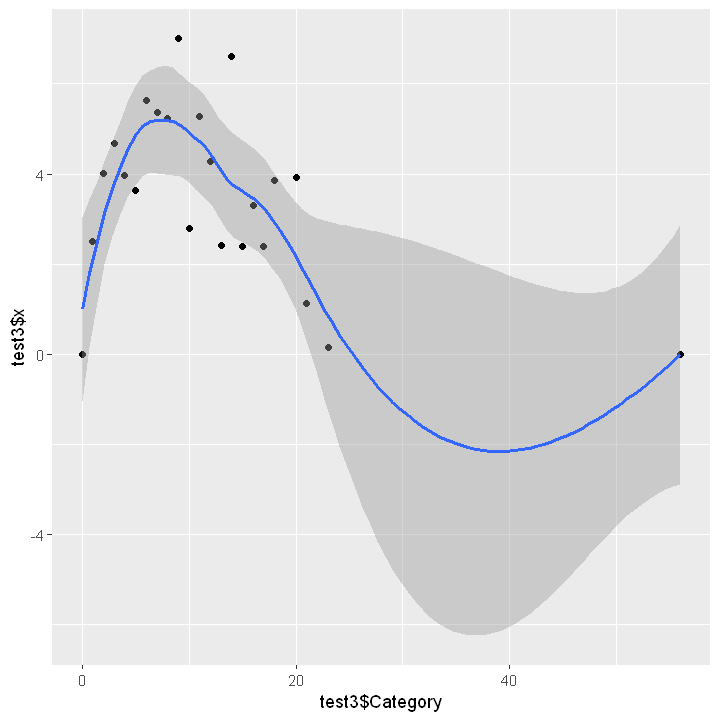

In [84]:
# grouping and choose only max value

test=data.frame(oISI2=round(oISI), oLogArea)
test3=aggregate(test$oLogArea, by = list(Category=test$oISI2), max)

#plot(test3$Category, test3$x)
#m1<-lm(test3$x ~ test3$Category, data=test3)
#abline(coef(m1), col = "blue")
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="lm") 
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="loess")

#### Wind

#### Rain

## Secondary Effects

# _Rishi: Here is your stuff from the bottom of your notebook.  Move it as you see fit._

In [67]:
ffXYgroup = bff %>%
    group_by(X, Y) %>%
    summarize(logMeanArea = log(mean(area)), meanArea = mean(area), 
              medianArea = median(area), count = n(), totalArea = sum(area))

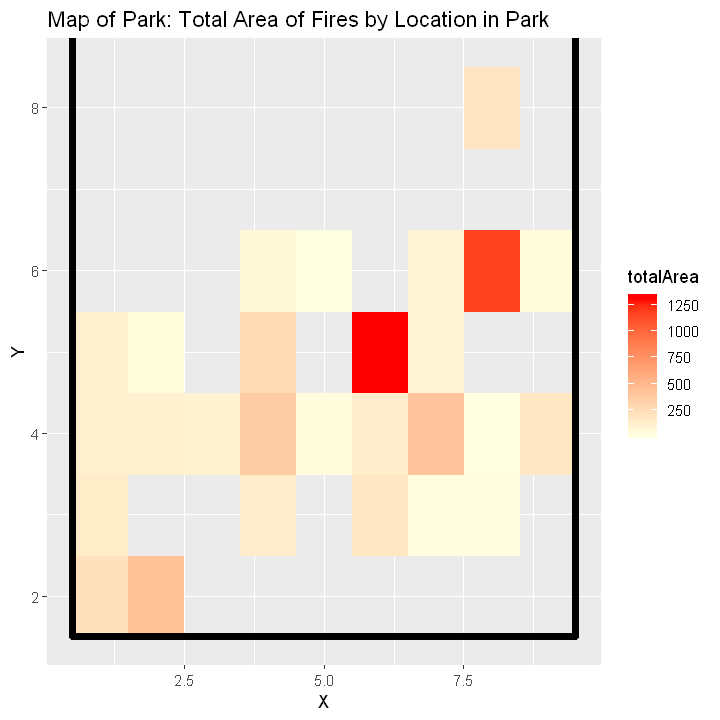

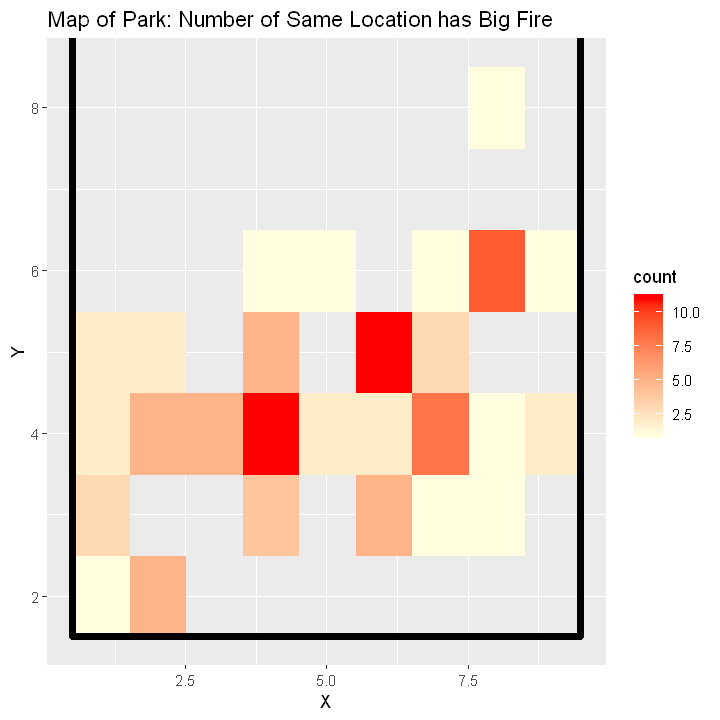

In [71]:
ggplot(ffXYgroup, aes(x=X, y=Y, fill=totalArea)) +
  geom_raster() + 
  scale_fill_gradient(low= "light yellow", high="Red") + 
  geom_rect(xmin=0.5, xmax=9.5, ymin=1.5, ymax=9.5, color="black", fill=NA, size=2) +
  ggtitle("Map of Park: Total Area of Fires by Location in Park")

ggplot(ffXYgroup, aes(x=X, y=Y, fill=count)) +
  geom_raster() + 
  scale_fill_gradient(low= "light yellow", high="Red") + 
  geom_rect(xmin=0.5, xmax=9.5, ymin=1.5, ymax=9.5, color="black", fill=NA, size=2) +
  ggtitle("Map of Park: Number of Same Location has Big Fire")

- Interactions between temperature and Month
- FFMC / DMC
- 

## Conclusion

In [ ]:
#severe forest fire
sff = 
